# Проект: модели машинного обучения для выбора коров

В проекте необходимо разработать модель машинного обучения, которая поможет владельцу молочного хозяйства «Вольный луг» управлять рисками и принимать объективное решение о покупке коров, на основе подробных данных о коровах «ЭкоФермы»


Нужно создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать возможный удой коровы (целевой признак `Удой`); 
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак `Вкус молока`).


С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

Описание данных:
- файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент: 
    - `id` — уникальный идентификатор коровы.
    - `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
    - `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
    - `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
    - `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Жирность,%` — содержание жиров в молоке (в процентах).
    - `Белок,%` — содержание белков в молоке (в процентах).
    - `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    - `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет);
- файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера:
    - `id` — уникальный идентификатор коровы.
    - `Имя Папы` — имя папы коровы;
- файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой:
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Имя_папы` — имя папы коровы.
    - `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
    - `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
    - `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
    

Данные в файлах `ferma_main.csv` и `cow_buy.csv` похожи, но у датасета `cow_buy.csv` несколько особенностей:
- Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм;
- Параметры корма `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%;
- Кроме того, отсутствуют признаки `Удой, кг` и `Вкус молока`. Это целевые признаки, которые предстоит предсказать.


В проекте будет несколько блоков:
1. загрузка данных и изучение общей информации;
2. предобработка данных;
3. исследовательский анализ;
4. корреляционный анализ;
5. обучение модели линейной регрессии;
6. обучение модели логистической регрессии;
7. общий вывод.

## 1. Загрузка данных и изучение общей информации

Для начала работы импортируем (установим) все необходимые в прокте библиотеки:

In [1]:
! pip install phik -q # -q убирает необязательные выводы в командах Linux

In [2]:
import phik

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings('ignore')

Загрузим данные о стаде фермера на текущий момент, именах папы коровы и данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой:

In [3]:
#Считываем данные и сохраняем в переменные: ferma_main, ferma_dad и cow_buy
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

# выводим первые 5 строк каждого датафрейма
for i in ferma_main, ferma_dad, cow_buy:
    display(i.head(5))

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

Для дальнейшего удобства приведем названия столбцов в удобный вид (английский язык и змеиный регистр):

In [4]:
# переименуем названия столбцов на названия на английском языке и со змеиным регистром во всех датафреймах
ferma_main.rename(columns = {'Удой, кг':'milk_yield', 
                             'ЭКЕ (Энергетическая кормовая единица)':'efu', # energy food unit 
                             'Сырой протеин, г':'raw_protein', 
                             'СПО (Сахаро-протеиновое соотношение)':'spr', # sugar-protein ratio
                             'Порода':'breed',
                             'Тип пастбища':'type_of_pasture',
                             'порода папы_быка':'breed_dad_bull',
                             'Жирность,%':'fat_content',
                             'Белок,%':'protein',
                             'Вкус молока':'taste_milk',
                             'Возраст':'age'
                            }, inplace = True
                 )

ferma_dad.rename(columns = {'Имя Папы':'dad_bull_name'}, inplace = True)

cow_buy.rename(columns = {'Порода':'breed',
                          'Тип пастбища':'type_of_pasture',
                          'порода папы_быка':'breed_dad_bull',
                          'Имя_папы':'dad_bull_name',
                          'Текущая_жирность,%':'fat_content',
                          'Текущий_уровень_белок,%':'protein',
                          'Возраст':'age'
                         }, inplace = True
                 )

Посмотрим информацию о датафреймах с помощью метода `info()`:

In [5]:
for i in ferma_main, ferma_dad, cow_buy:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   milk_yield       634 non-null    int64  
 2   efu              634 non-null    float64
 3   raw_protein      634 non-null    int64  
 4   spr              634 non-null    float64
 5   breed            634 non-null    object 
 6   type_of_pasture  634 non-null    object 
 7   breed_dad_bull   634 non-null    object 
 8   fat_content      634 non-null    float64
 9   protein          634 non-null    float64
 10  taste_milk       634 non-null    object 
 11  age              634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             629 non-null    int64 
 1   dad_bull_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed            20 non-null     object 
 1   type_of_pasture  20 non-null     object 
 2   breed_dad_bull   20 non-null     object 
 3   dad_bull_name    20 non-null     object 
 4   fat_content      20 non-null     float64
 5   protein          20 non-null     float64
 6   age              20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

Посмотрим на числовое описание данных:

In [6]:
for i in ferma_main, cow_buy:
    display(i.describe())

id    milk_yield         efu  raw_protein         spr  \
count  634.000000    634.000000  634.000000   634.000000  634.000000   
mean   317.460568   6187.025237   14.542744  1922.682965    0.912855   
std    183.096982   1638.401021    1.301301   182.392548    0.032209   
min      1.000000   5204.000000   10.900000  1660.000000    0.840000   
25%    159.250000   5751.750000   13.500000  1772.250000    0.890000   
50%    317.500000   6130.500000   14.700000  1880.500000    0.930000   
75%    475.750000   6501.000000   15.600000  2058.750000    0.940000   
max    629.000000  45616.000000   16.800000  2349.000000    0.960000   

       fat_content     protein  
count   634.000000  634.000000  
mean      3.603943    3.075666  
std       0.168020    0.002540  
min       2.990000    3.069000  
25%       3.590000    3.074000  
50%       3.650000    3.076000  
75%       3.720000    3.077000  
max       3.750000    3.085000

fat_content    protein
count    20.000000  20.000000
mean      3.577500   3.069500
std       0.126818   0.010339
min       3.340000   3.046000
25%       3.510000   3.064000
50%       3.590000   3.074000
75%       3.650000   3.076000
max       3.770000   3.081000

Вывод по первому блоку:
- `ferma_main`:
    - всего 12 колонок и 634 не нулевых строки, без пропусков, необходимо будет заменить тип данных `object` на `category`;
    - максимальное значение в столбце `milk_yield` сильно больше среднего (выброс?);
- `ferma_dad`:
    - всего 2 колонки и 629 не нулевых строки строки, без пропусков, необходимо будет заменить тип данных `object` на `category`;
- `cow_buy`:
    - всего 7 колонок и 20 не нулевых строки, без пропусков, необходимо будет заменить тип данных `object` на `category`;
    - количественные признаки в таких же пределах, как и подобные признеаки в `ferma_main`;
- количество строк `ferma_main` и `ferma_dad` не совпадают, необходимо разобраться почему.

##  2. Предобработка данных

###  2.1 Проверка на наличие явных и неявных дубликатов

Посмотрим посмотрим на уникальные значения категориальных данных в датафреймах:

In [7]:
# выделим столбцы с категориальными данными
cat_col_names = ['breed','type_of_pasture', 'breed_dad_bull', 'taste_milk', 'age', 'dad_bull_name']

# выведем все уникальные значения столбцоы с категориальными данными
for i in cat_col_names:
    try:
        display(f'Уникальные значения столбца "{i}" в "ferma_main": {ferma_main[i].sort_values().unique()}')       
    except:
        pass
    try:
        display(f'Уникальные значения столбца "{i}" в "ferma_dad" : {ferma_dad[i].sort_values().unique()}')  
    except:
        pass
    try:
        display(f'Уникальные значения столбца "{i}" в "cow_buy"   : {cow_buy[i].sort_values().unique()}')        
    except:
        pass

'Уникальные значения столбца "breed" в "ferma_main": [\'Вис Бик Айдиал\' \'РефлешнСоверинг\']'

'Уникальные значения столбца "breed" в "cow_buy"   : [\'Вис Бик Айдиал\' \'РефлешнСоверинг\']'

'Уникальные значения столбца "type_of_pasture" в "ferma_main": [\'Равнинное\' \'Равнинные\' \'Холмистое\']'

'Уникальные значения столбца "type_of_pasture" в "cow_buy"   : [\'равнинное\' \'холмистое\']'

'Уникальные значения столбца "breed_dad_bull" в "ferma_main": [\'Айдиал\' \'Айдиалл\' \'Соверин\']'

'Уникальные значения столбца "breed_dad_bull" в "cow_buy"   : [\'Айдиал\' \'Соверин\']'

'Уникальные значения столбца "taste_milk" в "ferma_main": [\'вкусно\' \'не вкусно\']'

'Уникальные значения столбца "age" в "ferma_main": [\'более_2_лет\' \'менее_2_лет\']'

'Уникальные значения столбца "age" в "cow_buy"   : [\'более_2_лет\' \'менее_2_лет\']'

'Уникальные значения столбца "dad_bull_name" в "ferma_dad" : [\'Барин\' \'Буйный\' \'Геркулес\' \'Соловчик\']'

'Уникальные значения столбца "dad_bull_name" в "cow_buy"   : [\'Барин\' \'Буйный\' \'Геркулес\' \'Соловчик\']'

Видно, что:
- в столбце `type_of_pasture` в `ferma_main` есть один неявный дубликат `Равнинные`, необходимо изменить его на `равнинное`, а также для однообразия с `cow_buy` необходимо заменить все символы на строчные;
- в столбце `breed_dad_bull` в `ferma_main` есть один неявный дубликат `Айдиалл`, необходимо изменить его на `Айдиал`;
- в остальных столбцах все хорошо.

In [8]:
# замена неявных дубликатов в type_of_pasture
ferma_main['type_of_pasture'] = ferma_main['type_of_pasture'].replace({'Равнинные': 'равнинное', 
                                                                       'Равнинное': 'равнинное', 
                                                                       'Холмистое': 'холмистое'})

# замена неявных дубликатов в breed_dad_bull
ferma_main['breed_dad_bull'] = ferma_main['breed_dad_bull'].replace('Айдиалл', 'Айдиал')

Проверим датафреймы на наличие явных дубликатов:

In [9]:
print('Количество явных дубликатов ferma_main:', ferma_main.duplicated().sum())
print('Количество явных дубликатов ferma_dad:', ferma_dad.duplicated().sum())
print('Количество явных дубликатов cow_buy:', cow_buy.duplicated().sum())

Количество явных дубликатов ferma_main: 5
Количество явных дубликатов ferma_dad: 0
Количество явных дубликатов cow_buy: 4


Удалим строки с явными дубликатами в `ferma_main` и `cow_buy`:

In [10]:
# удаляем явные дубликаты и сбрасываем индексы в ferma_main
ferma_main = ferma_main.drop_duplicates(keep='first').reset_index(drop=True)
print(f'Размер ferma_main: {ferma_main.shape}')

# удаляем явные дубликаты и сбрасываем индексы в cow_buy
cow_buy = cow_buy.drop_duplicates(keep='first').reset_index(drop=True)
print(f'Размер cow_buy: {cow_buy.shape}')

Размер ferma_main: (629, 12)
Размер cow_buy: (16, 7)


Теперь число строк в `ferma_main` совпадает c датафреймом `ferma_dad`.

###  2.2 Замена типов данных

У столбцов с категориальными признаками `breed`, `type_of_pasture`, `breed_father_bull`, `taste_milk`, `age`, `father_bull_name` во всех датафреймах заменим тип на `category`:

In [11]:
# замена типов категориальных данных на category в ferma_main
ferma_main[['breed', 'type_of_pasture', 'breed_dad_bull', 'taste_milk', 'age']] = \
ferma_main[['breed', 'type_of_pasture', 'breed_dad_bull', 'taste_milk', 'age']].astype('category')

# замена типов категориальных данных на category в ferma_dad
ferma_dad['dad_bull_name'] = ferma_dad['dad_bull_name'].astype('category')

# замена типов категориальных данных на category в cow_buy
cow_buy[['breed', 'type_of_pasture', 'breed_dad_bull', 'dad_bull_name', 'age']] = \
cow_buy[['breed', 'type_of_pasture', 'breed_dad_bull', 'dad_bull_name', 'age']].astype('category')

Вывод по второму блоку:
- заменены некорректные записи (ошибки в написании) категориальных данных;
- удалены явные удбликаты в `ferma_main` и `cow_buy`;
- заменены типы данных для столбцов с категориальными признаками.

## 3. Исследовательский анализ данных

### 3.1 Анализ количественных признаков

Построим гистограммы и "ящики с усами" для количественных признаков в `ferma_main`, предварительно создав функцию для их построения:

In [12]:
# создадим функцию для построения гистограммы и ящика с усами для количетсвенных признаков
def hist_and_boxplot_num_col (df, parametr):
    # вывод числового описания данных
    display(df[parametr].describe())
    
    # выбор количества корзин
    if ((len(df[parametr].unique())) >= 20):
        bins = 20
    else:
        bins = len(df[parametr].unique())
    
    # построение гистограммы
    df[parametr].hist(
        bins=bins, # количество корзин
        figsize=(14, 6), # размер графика
        grid=True # сетка
    )
    plt.ylabel('Количество', fontsize=15)
    plt.title(f'Распределение признака {parametr}', fontsize=20)
    plt.show()
    
    # построение ящика с усами
    df.boxplot(
        column=parametr, # выбор параметра
        vert=0, # поворот графика
        figsize=(14, 6) # размер графика
    )
    plt.xlabel(f'Значение признака {parametr}', fontsize=15)

Посмотрим на графики для удоя `milk_yield`:

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: milk_yield, dtype: float64

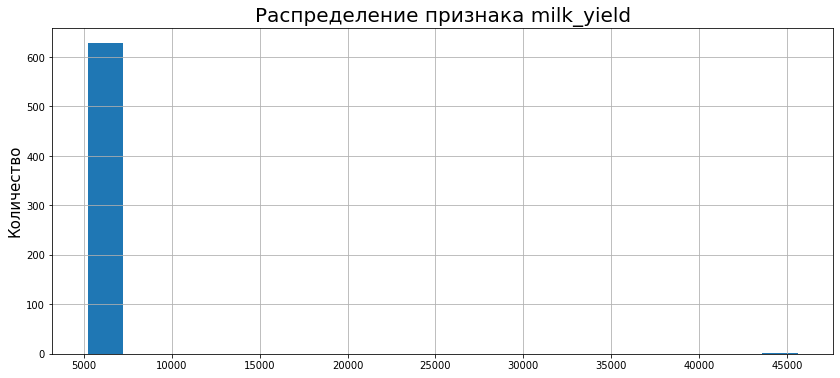

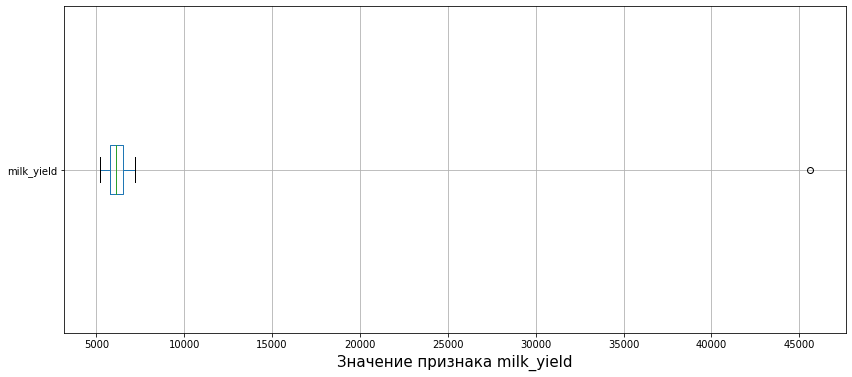

In [13]:
# выведем графики для milk_yield
hist_and_boxplot_num_col(ferma_main, 'milk_yield')

Вот это аномальное значение, которое смутило при первичном анализе, это однозначно выброс от которого нужно избавиться, такой выброс сильно повлияет на качество модели МО:

In [14]:
ferma_main = ferma_main.query('milk_yield < 10000')
ferma_main.shape

(628, 12)

Размер датафрейма уменьшился на 1 строчку.

Посмотрим на графики обновленнойго датафрейма:

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_yield, dtype: float64

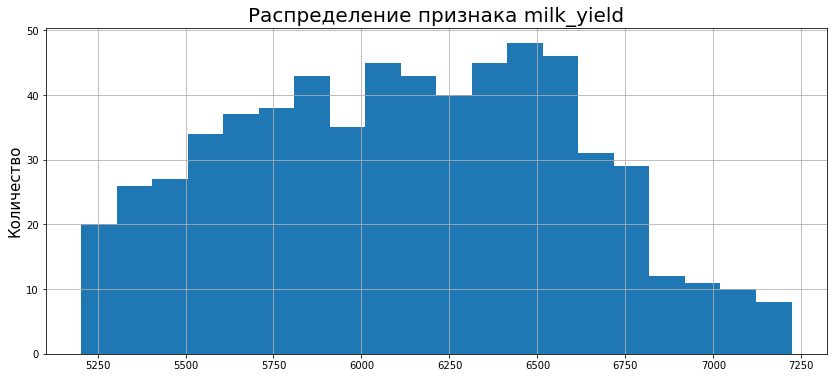

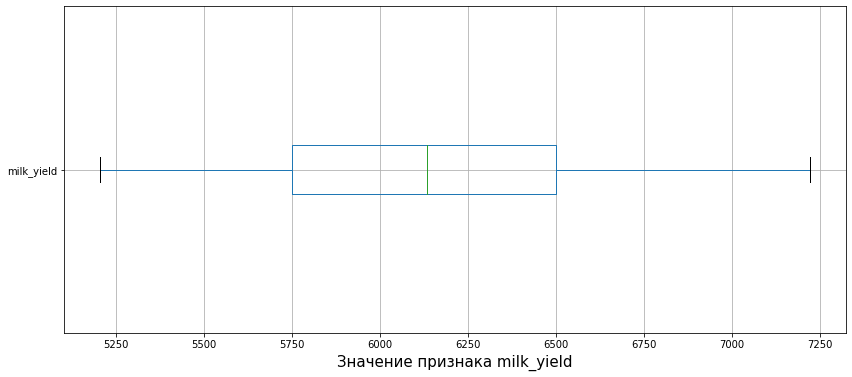

In [15]:
# выведем графики для milk_yield, без выброса
hist_and_boxplot_num_col(ferma_main, 'milk_yield')

По графикам распределения `milk_yield` можно сделать следующие выводы:
- распределение похоже на нормальное;
- все значения расположены в пределах нормального значения параметра;
- медианное и среднее значения (6130 кг. и 6125 кг. соответственно) близки друг к другу.

Посмотрим на графики показателя питательности корма коровы `efu`:

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: efu, dtype: float64

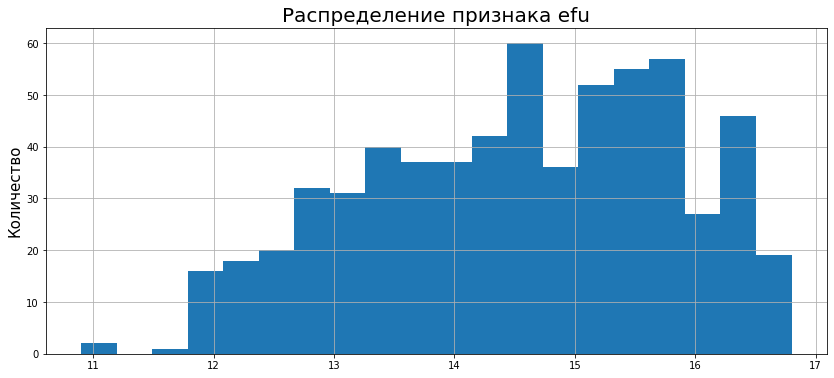

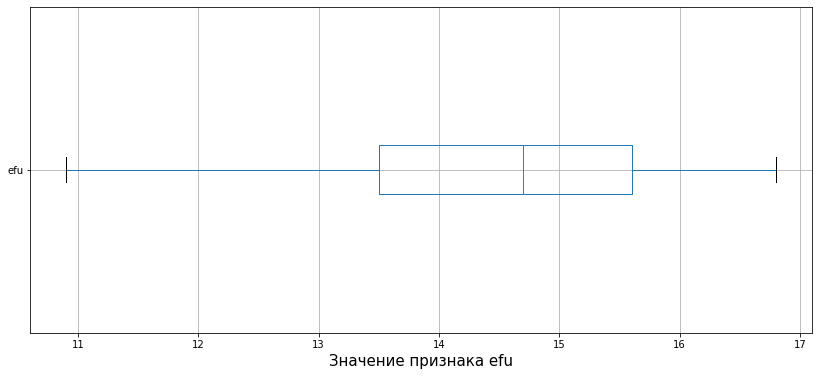

In [16]:
# выведем графики для efu
hist_and_boxplot_num_col(ferma_main, 'efu')

По графикам распределения `efu` можно сделать следующие выводы:
- распределение не похоже на нормальное, т.к. есть несколько пиков на 14,5, 15,5 и 16,5;
- все значения расположены в пределах нормального значения параметра;
- медианное и среднее значения (14,7 и 14,5 соответственно) близки друг к другу.

Посмотрим на графики содержания сырого протеина в корме `raw_protein`:

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: raw_protein, dtype: float64

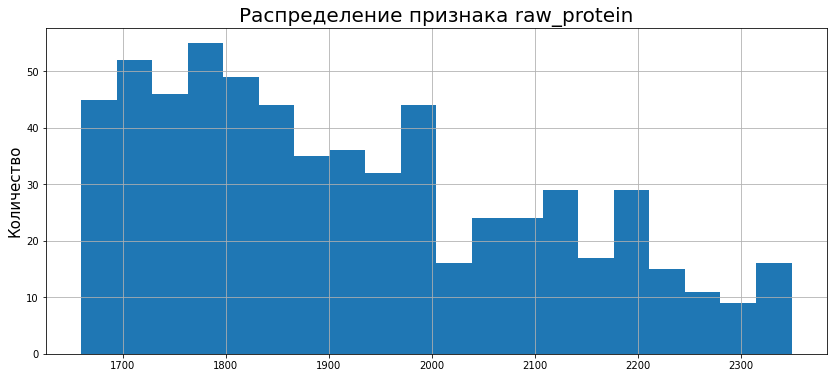

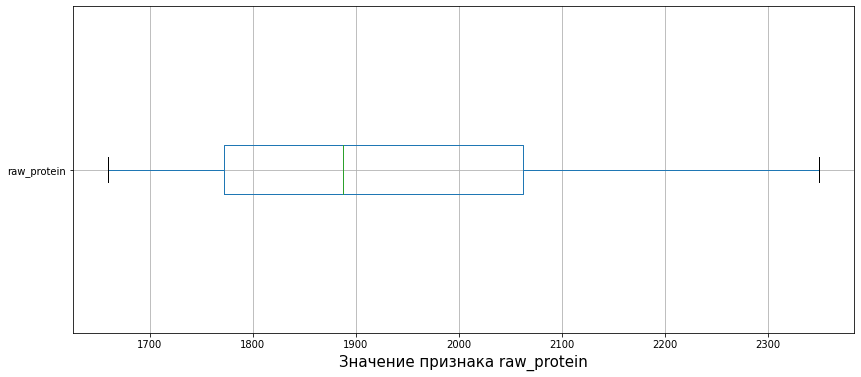

In [17]:
# выведем графики для raw_protein
hist_and_boxplot_num_col(ferma_main, 'raw_protein')

По графикам распределения `raw_protein` можно сделать следующие выводы:
- распределение не похоже на нормальное, т.к. есть много пиков;
- все значения расположены в пределах нормального значения параметра;
- медианное и среднее значения (1888 гр. и 1923 гр. соответственно) не очень близки друг к другу.

Посмотрим на графики отношения сахара к протеину в корме коровы `spr`:

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: spr, dtype: float64

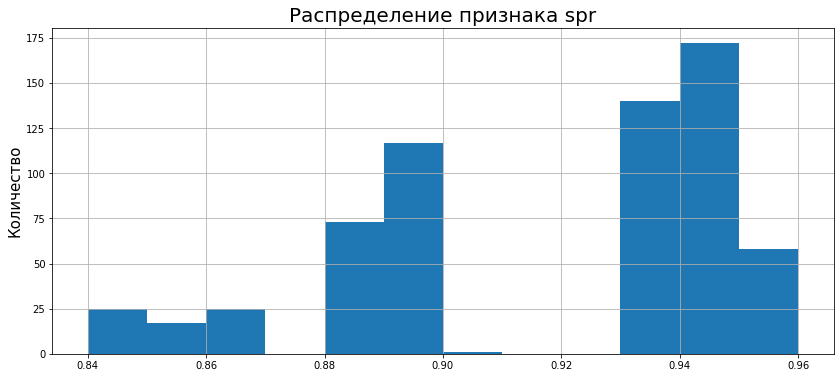

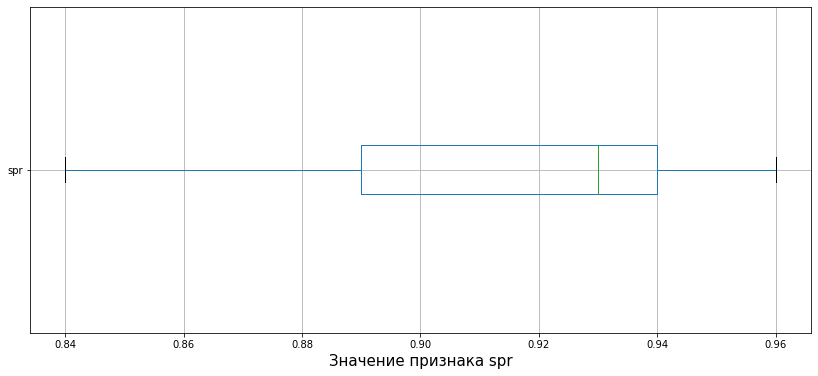

In [18]:
# выведем графики для spr
hist_and_boxplot_num_col(ferma_main, 'spr')

По графикам распределения `spr` можно сделать следующие выводы:
- распределение не похоже на нормальное, т.к. можно выделить три отдельных "распределения", это похоже на три вида корма по отношению сахара к протеину в корме коровы;
- все значения расположены в пределах нормального значения параметра.

Посмотрим на графики содержания жиров в молоке `fat_content`:

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_content, dtype: float64

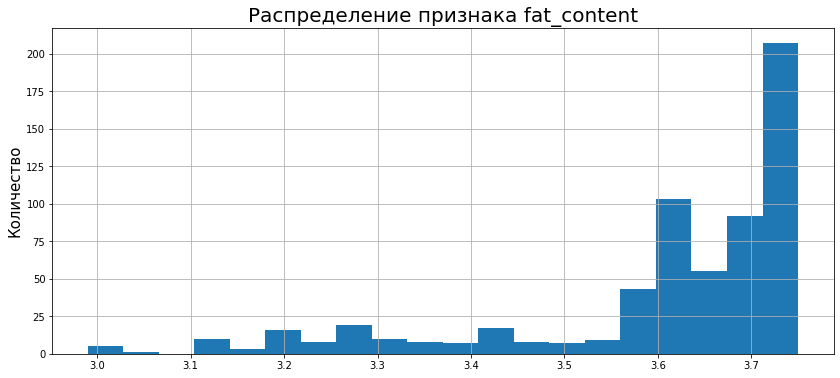

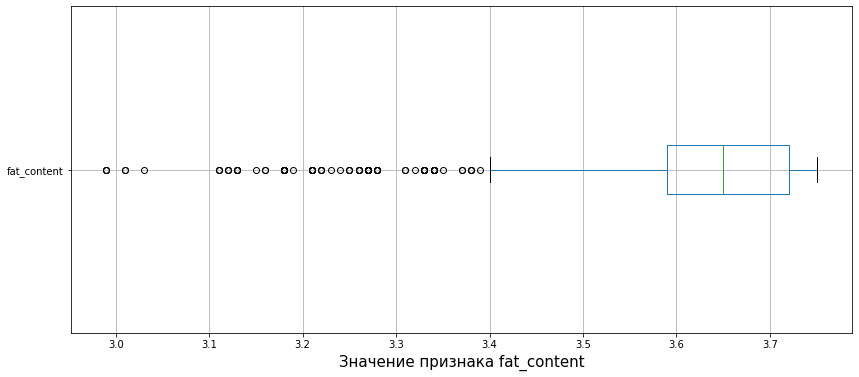

In [19]:
# выведем графики для fat_content
hist_and_boxplot_num_col(ferma_main, 'fat_content')

По графикам распределения `fat_content` можно сделать следующие выводы:
- распределение не похоже на нормальное, т.к. можно выделить два ярковыаженных пика
- не все значения расположены в пределах нормального значения параметра, есть много выбросов меньше нормальных значений, но такие значения вполне возможны, они отличаются от основной массы не в разы, это не выбросы.

Посмотрим на графики содержания белков в молоке `protein`:

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein, dtype: float64

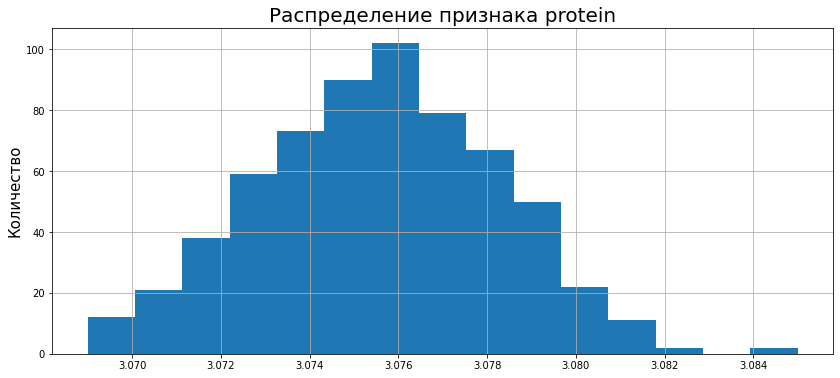

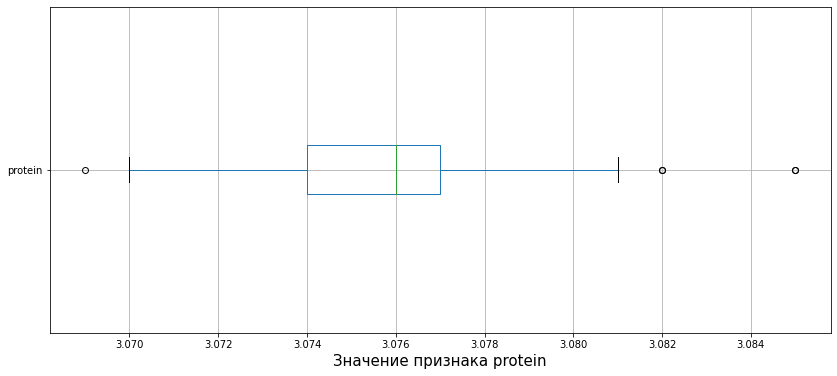

In [20]:
# выведем графики для protein
hist_and_boxplot_num_col(ferma_main, 'protein')

По графикам распределения `protein` можно сделать следующие выводы:
- распределение похоже на нормальное, со средним значением (3,076 г)
- не все значения расположены в пределах нормального значения параметра, есть несколько выбросов за пределом нормальных значений, но такие значения вполне возможны, они отличаются от основной массы не в разы, это не выбросы.

### 3.2 Анализ категориальных признаков

Сначала также создадим функцию, которая будет строить графики для категориальных переменных:

In [21]:
# создадим функцию для постройки столбчатого графика для категориальных признаков
def barplot_cat_col (df, parametr):
    df = df.groupby(by=parametr)[parametr].count()
    
    # построение барплота
    df.plot.bar(
        figsize=(9, 9), # размер графика
        grid=True, # сетка
        rot=0
    )
    plt.ylabel('Количество коров', fontsize=15)
    plt.xlabel(f'Признак: {parametr}', fontsize=15)
    plt.title(f'Распределение коров по признаку: {parametr}', fontsize=20)
    plt.show()

Теперь посмотрим на распределение категориальных признаков:

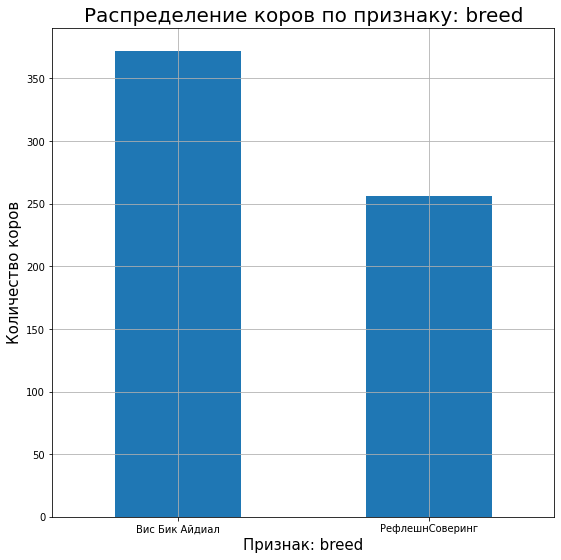

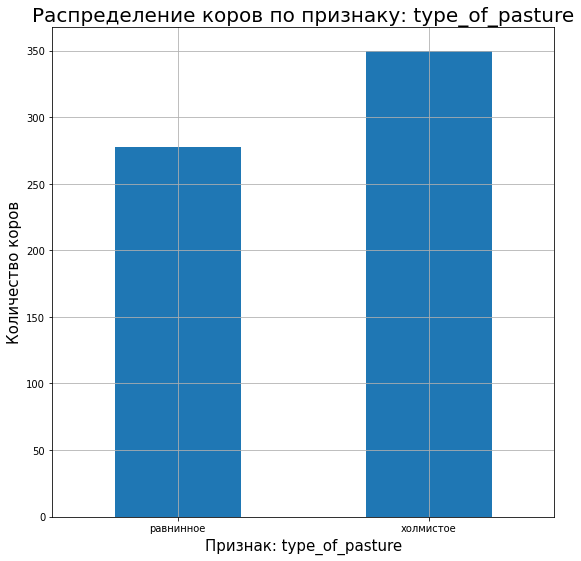

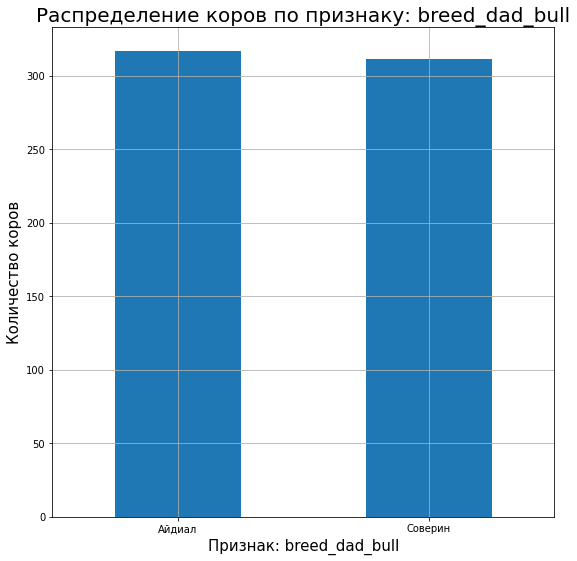

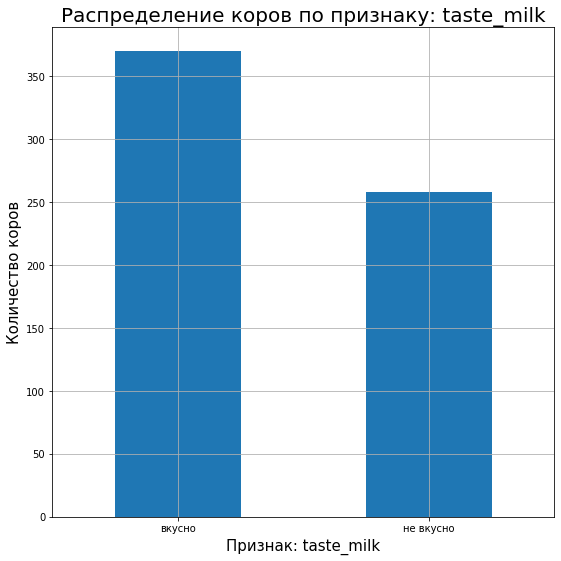

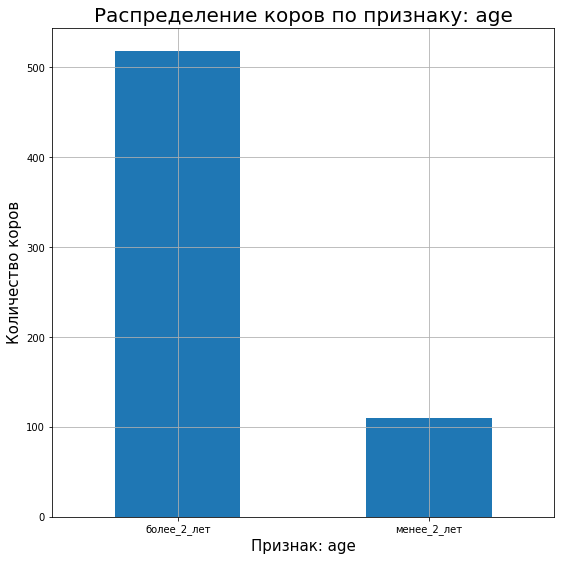

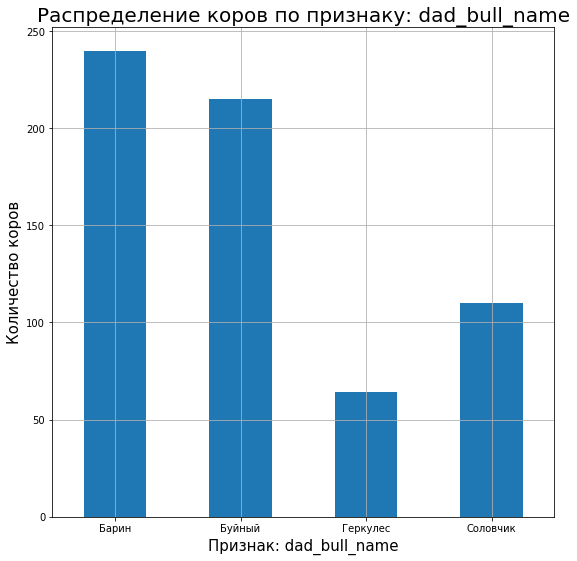

In [22]:
# построим столбчатые графики для категириальных признаков в ferma_main
for i in cat_col_names:
    try:
        barplot_cat_col(ferma_main, i)
    except:
        pass

# также посмотрим на распределение признака dad_bull_name в ferma_dad
barplot_cat_col(ferma_dad, 'dad_bull_name')

По графикам видно, что:
- коров породы Вис Бик Айдиал больше примерно на 120 голов, чем коров породы РефлешнСоверинг;
- коров, которые паслись на холмах примерно на 80 голов больше, чем коров пасшихся на равнине;
- породы пап этих коров разделились поровну;
- больше коров дают вкусное молоко;
- коров старше двух лет в 5 раз больше, чем коров младше двух лет;
- всех больше коров от быков-пап: Барин и Буйный.

## 4. Корреляционный анализ

Для нахождения зависимостей признаков воспользуемся коэффициентом Фи (указав в параметре `interval_cols` непрерывные признаки):

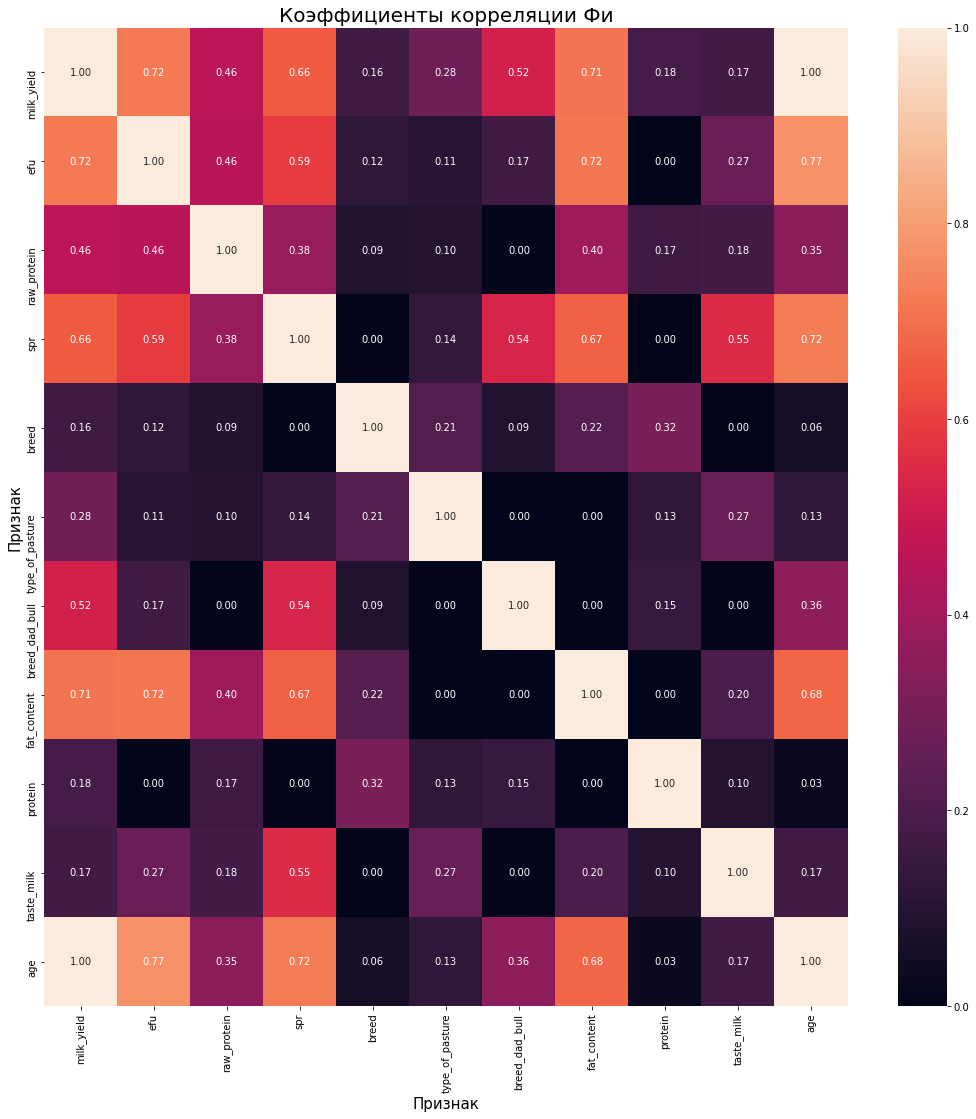

In [23]:
plt.subplots(figsize=(18, 18))
sns.heatmap(ferma_main.drop('id', axis=1)
                .phik_matrix(interval_cols=['milk_yield', 'efu', 'raw_protein', 'fat_content']), 
            annot=True, 
            fmt=".2f")
plt.ylabel('Признак', fontsize=15)
plt.xlabel('Признак', fontsize=15)
plt.title('Коэффициенты корреляции Фи', fontsize=20)
plt.show()

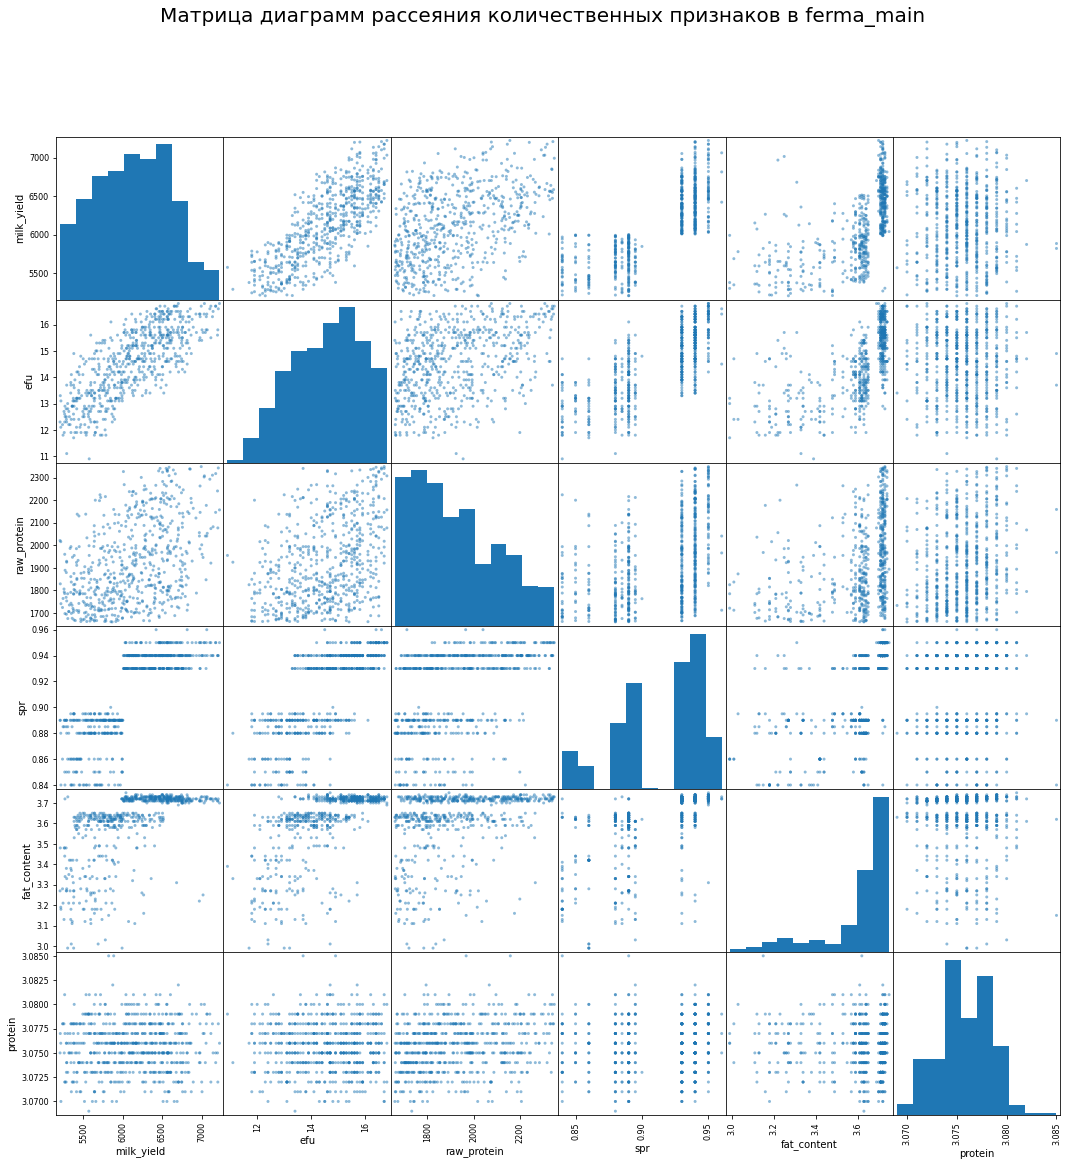

In [24]:
# построим матрицу диаграмм рассеяния количественных признаков
pd.plotting.scatter_matrix(ferma_main.drop('id', axis=1), figsize=(18, 18))
plt.suptitle('Матрица диаграмм рассеяния количественных признаков в ferma_main', fontsize=20)
plt.show()

По диаграммам рассеяния и тепловой карте коэффициентов Фи видно, что:
- удой `milk_yield` сильно зависит от возраста коровы `age` (коэффициент 1), а также от показателя питательности корма `efu`, жирности молока `fat_content` и отношения сахара к протеину в корме `spr` (коэффициент 0,72, 0,71 и 0,66 соответственно);
- удой `milk_yield` в меньшей степени зависит от породы быка-папы `breed_dad_bull` и от содержания сырого протеина в корме `raw_protein` и (коэффициент 0.52 и 0,46 соответственно);
- удой `milk_yield` практически не зависит от от пароды `breed`, типа пастбища `type_of_pasture`, вкуса молока `taste_milk` и содержания белков в молоке `protein`;
- среди зависимостей признаков между собой можно выделить высокую зависимость возраста коровы `age` от показателя питательности корма `efu`, отношения сахара к протеину в корме `spr` и жирности молока `fat_content` (коэффициент 0,77, 0,72 и 0,68 соответственно), а также высокая зависимость у показателя питательности корма `efu` и жирности молока `fat_content`(коэффициент 0,72);
- у остальных признаков зависимость между собой слабая.


Создадим функцию для построения диаграммы рассеяния для удоя `milk_yield` и количественных признаков с учётом значения категориальных признаков:

In [25]:
def draw_scatterplot(df, parametr_x, parametr_y, category):
    # создаем сетку для диаграмм
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 24))
    
    # название сетки
    plt.suptitle(f'Диаграммы рассеяния между удоем {parametr_y} и {parametr_x}', fontsize=20)
    
    # перебираем координаты сетки для диаграмм и строим диаграммы рассеяния при разных категориальных признаках
    for i in range(3):
        for j in range(2):
            try:
                sns.scatterplot(x=parametr_x, y=parametr_y, hue=category[(i*2+j)], data=df, ax=axes[i, j])
                axes[i,j].set_title(f'Разбиение по {category[(i*2+j)]}', fontsize=20)
                axes[i,j].set_xlabel(f'Значение {parametr_x}', fontsize=15)
                axes[i,j].set_ylabel(f'Значение {parametr_y}', fontsize=15)
                axes[i,j].grid()
            except:
                pass

Посмотрим на диаграммы рассеяния удоя `milk_yield` и показателя питательности корма коровы `efu`:

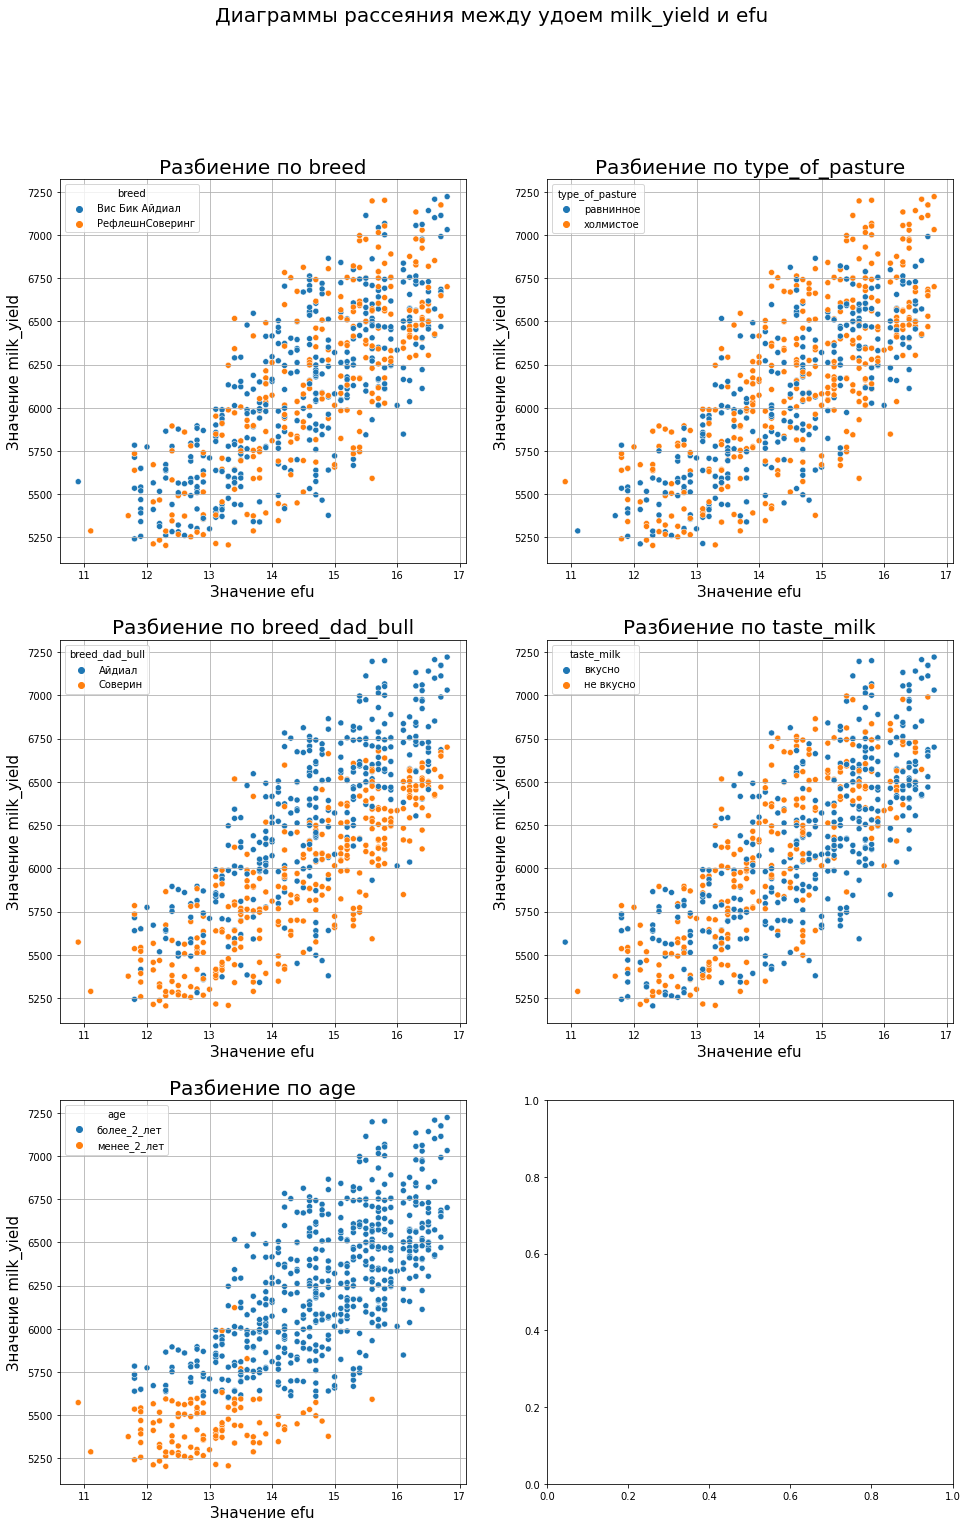

In [26]:
# строим диаграммы рассеяния для milk_yield и efu
draw_scatterplot(ferma_main, 'efu', 'milk_yield', cat_col_names)

Посмотрим на диаграммы рассеяния удоя `milk_yield` и содержания сырого протеина в корме `raw_protein`:

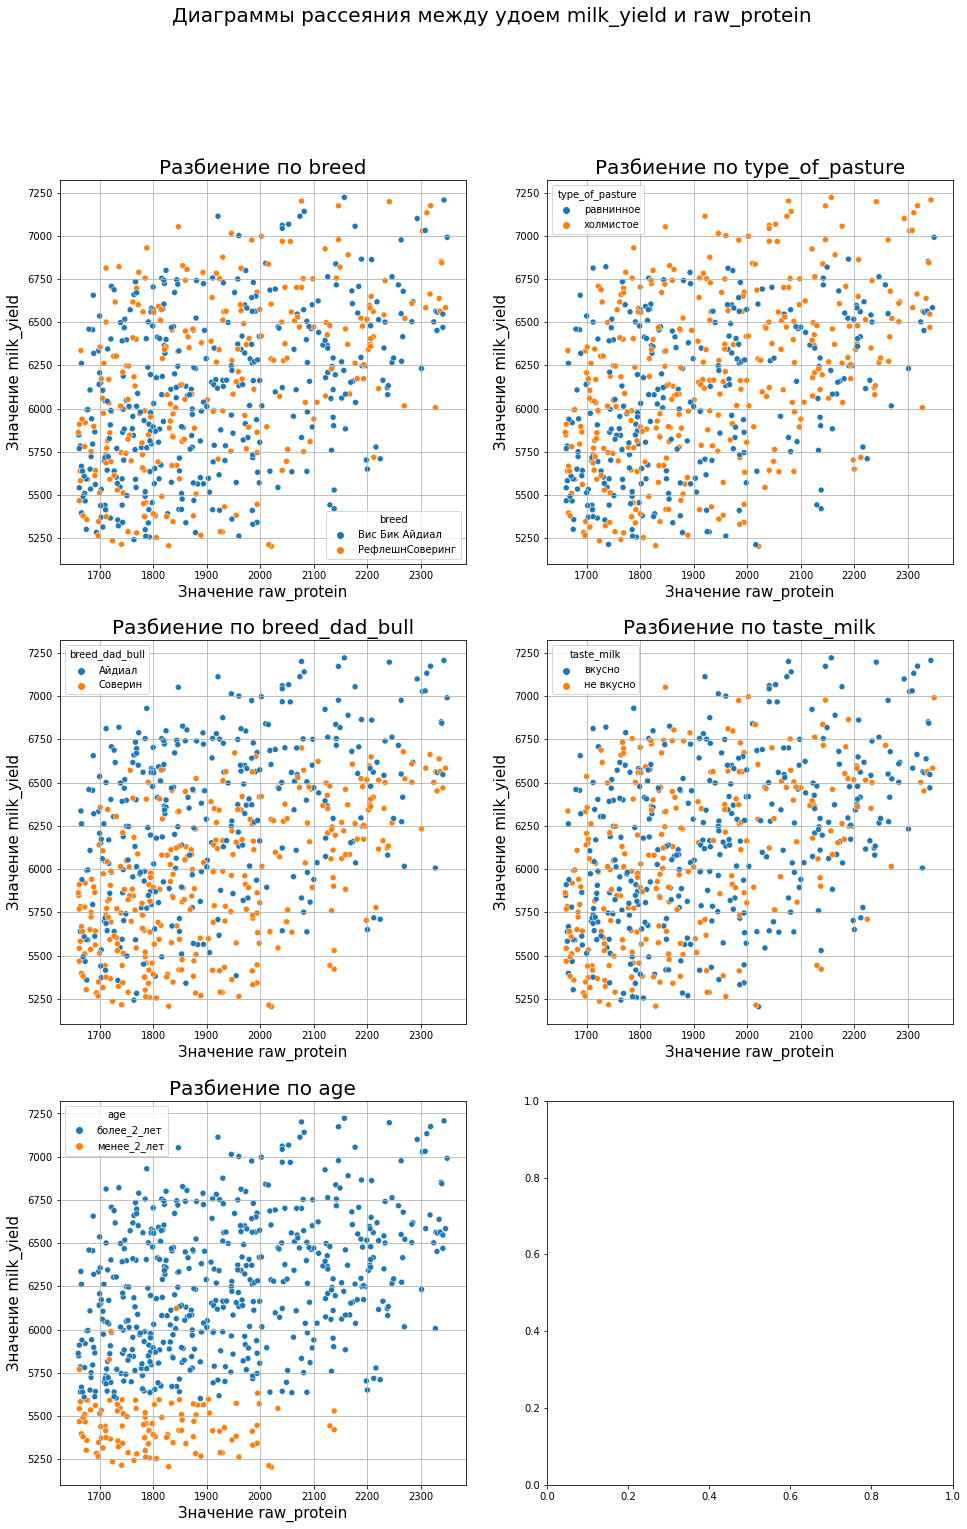

In [27]:
# строим диаграммы рассеяния для milk_yield и raw_protein
draw_scatterplot(ferma_main, 'raw_protein', 'milk_yield', cat_col_names)

Посмотрим на диаграммы рассеяния удоя `milk_yield` и отношения сахара к протеину в корме коровы `spr`:

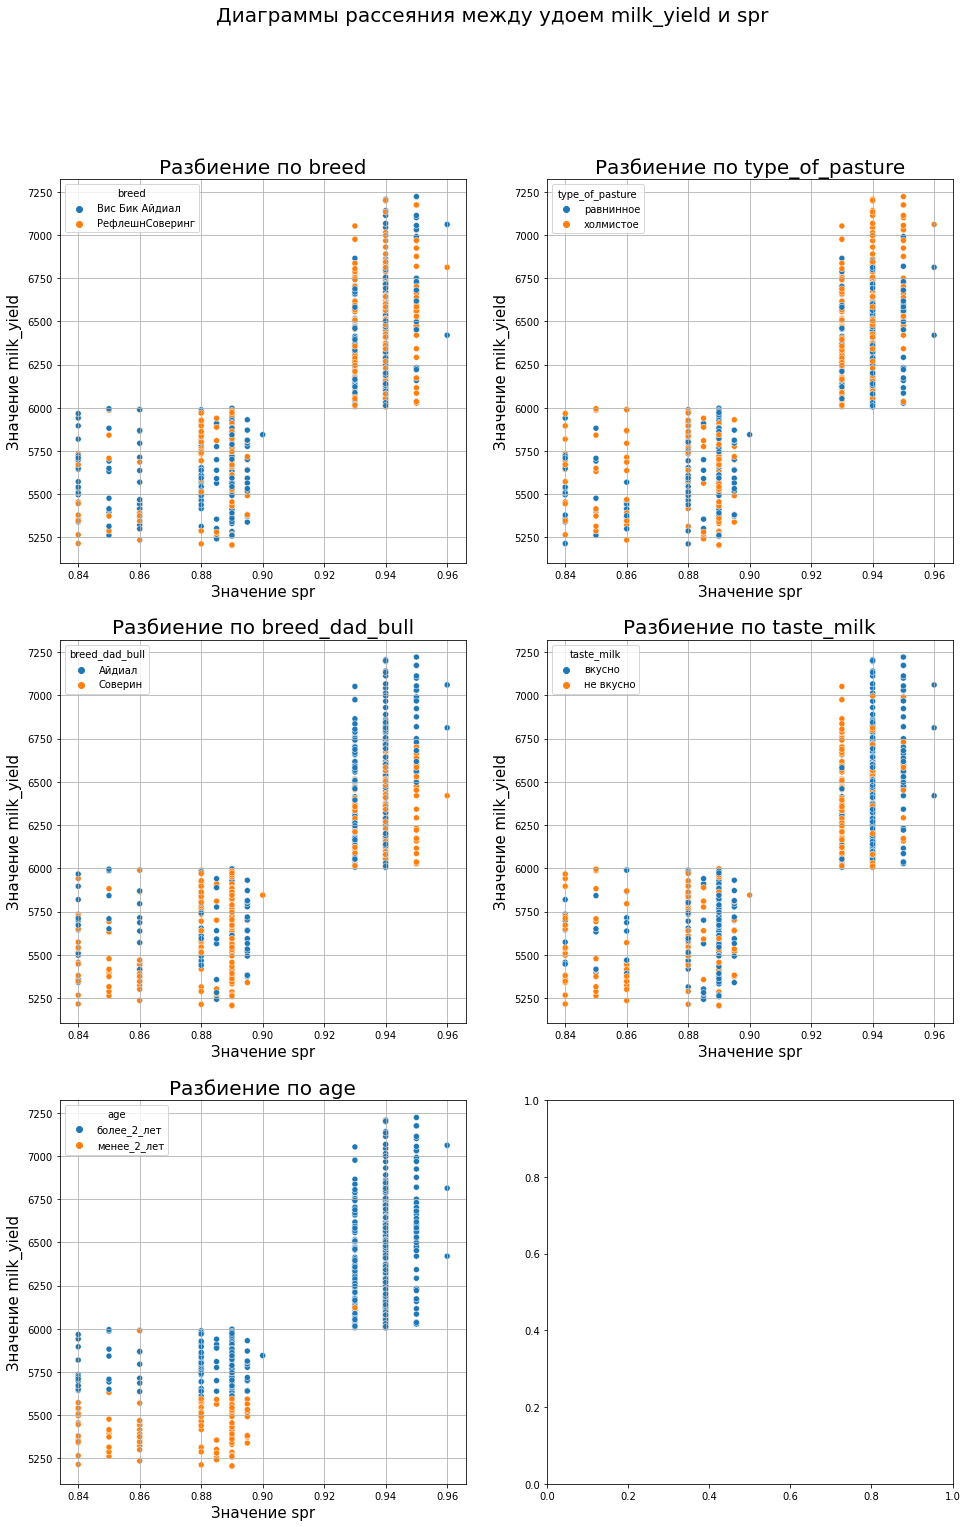

In [28]:
# строим диаграммы рассеяния для milk_yield и spr
draw_scatterplot(ferma_main, 'spr', 'milk_yield', cat_col_names)

Посмотрим на диаграммы рассеяния удоя `milk_yield` и содержания жиров в молоке `fat_content`:

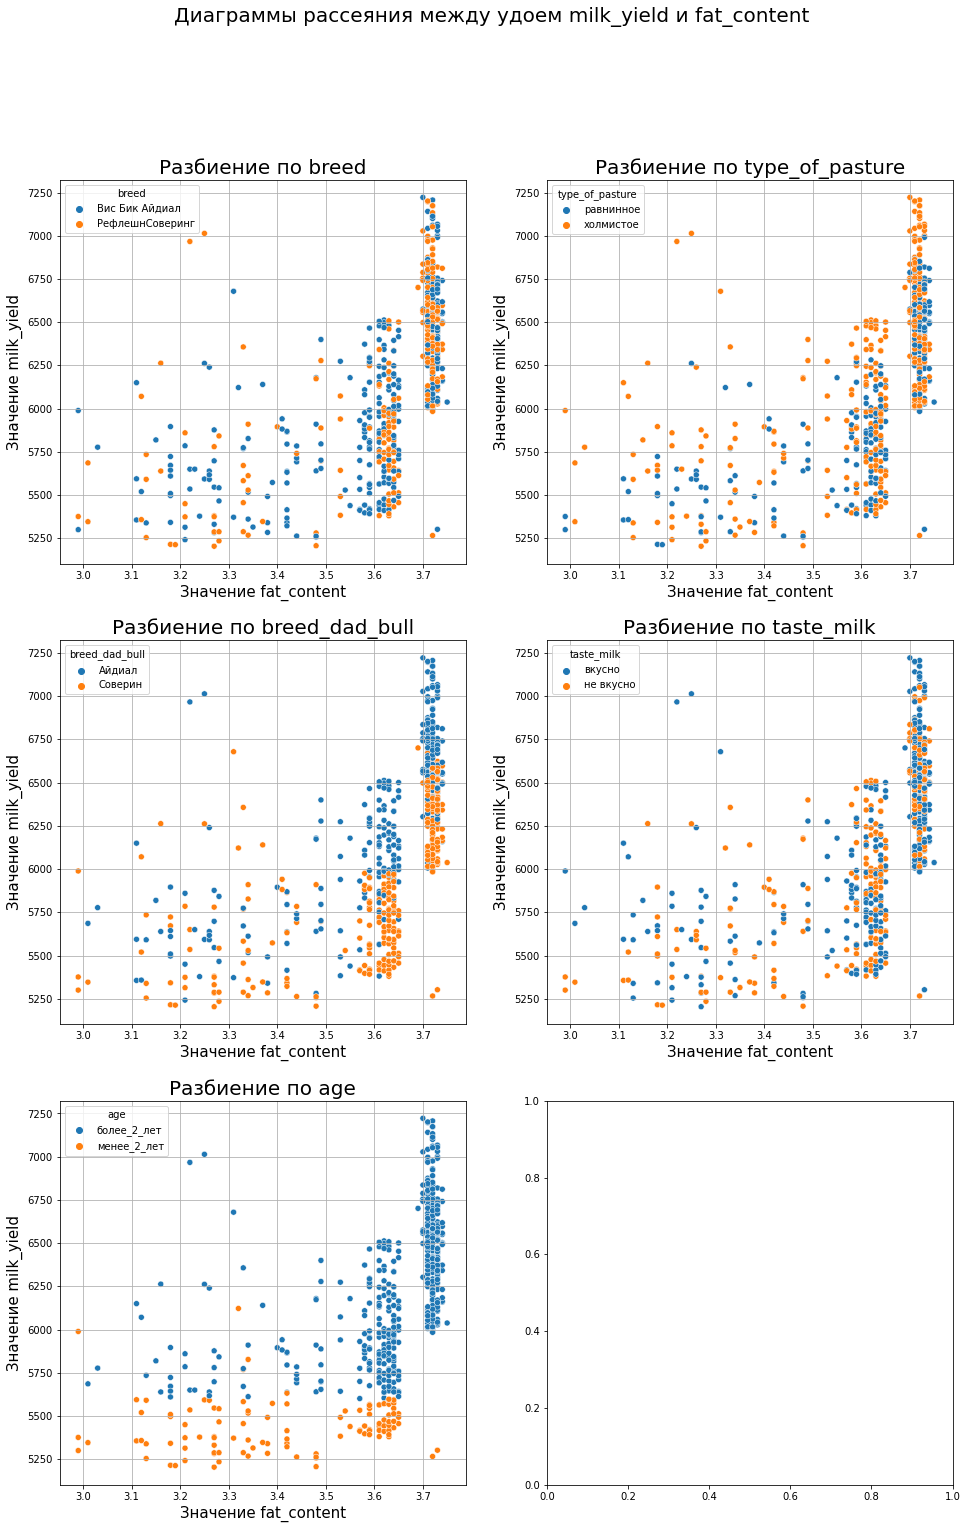

In [29]:
# строим диаграммы рассеяния для milk_yield и fat_content
draw_scatterplot(ferma_main, 'fat_content', 'milk_yield', cat_col_names)

Посмотрим на диаграммы рассеяния удоя `milk_yield` и содержания белков в молоке `protein`:

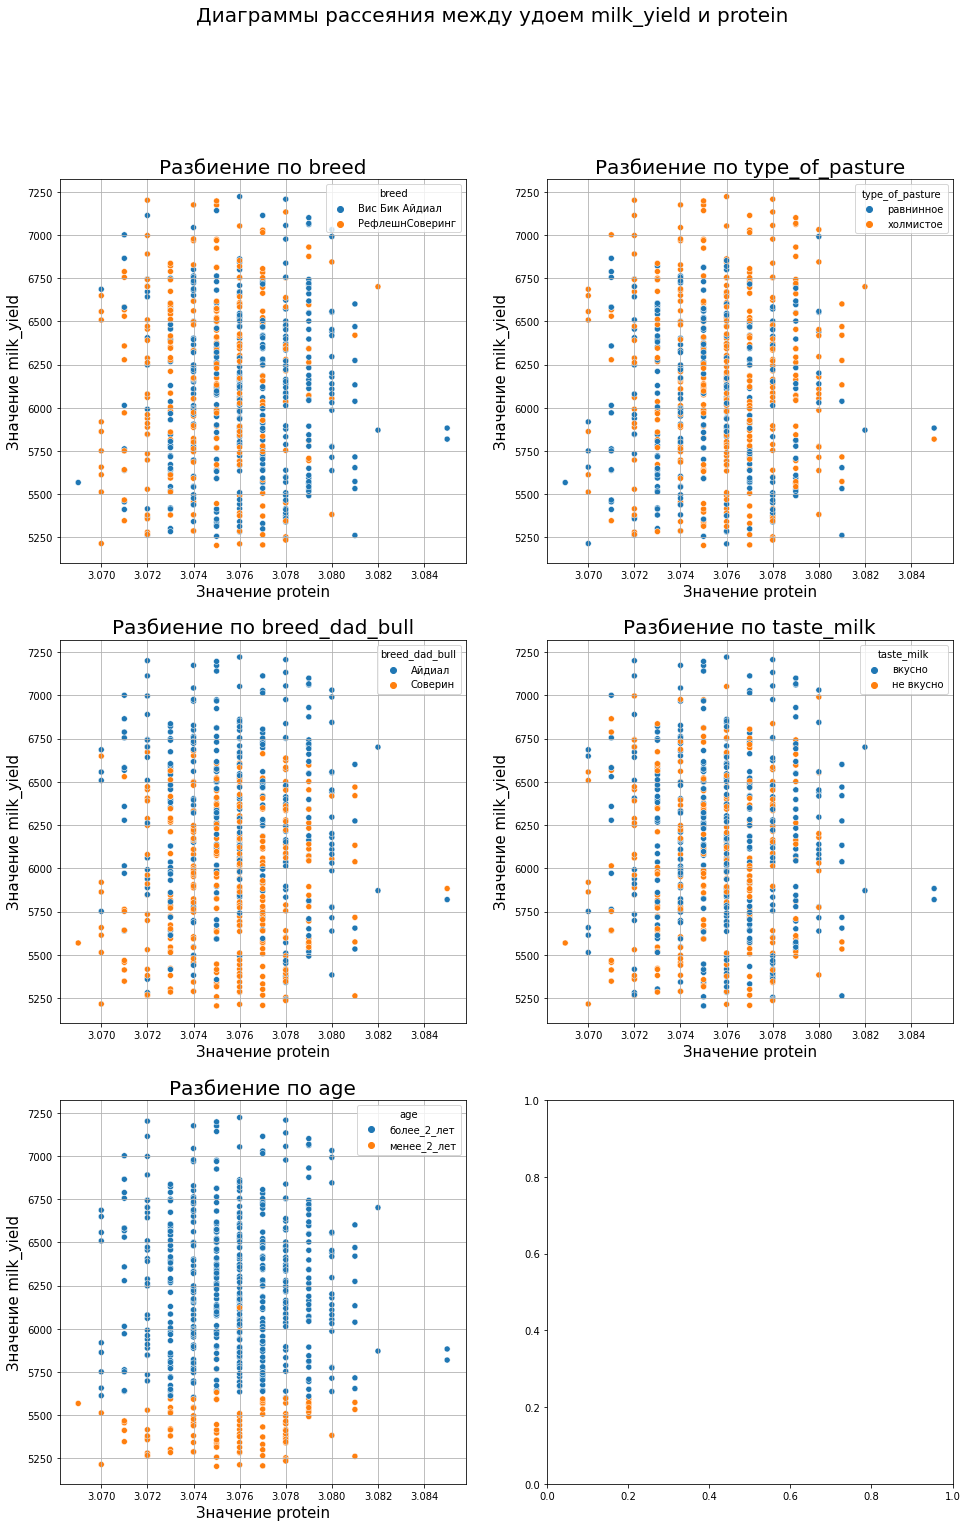

In [30]:
# строим диаграммы рассеяния для milk_yield и protein
draw_scatterplot(ferma_main, 'protein', 'milk_yield', cat_col_names)

По диаграммам рассеяния удоя `milk_yield` и количественных признаков с разбиением по категориальным признакам видно, что:
- при разбиении по возрасту коровы `age`, видна четкая граница (5600 кг. удоя), меньше которой коровы в возрасте страше 2 лет не дают молока (оно и не удивительно, ведь коэффициент Фи между удоем `milk_yield` и возрастом коровы `age` равен 1);
- при разбиении по породе папы-быка `breed_dad_bull` тоже проглядывается небольшая тенденция: коровы с папой-быком породы "Айдиал" дают больше молока (коэффициент Фи был 0,52);
- по остальным разбиениям все данные равномерно перемешаны между собой, никакой зависимости не просматривается.

Вывод по корреляционному анализу:
- между удоем `milk_yield` и показателем питательности корма `efu` и отношением сахара к протеину в корме `spr` есть небольшая линейная зависимость;
- также есть зависимость показателя удоя `milk_yield` от возраста коровы `age` и породы папы-быка `breed_dad_bull`;
- у остальных признаков взаимосвязь с удоем `milk_yield` не линейная;
- на диаграммах рассеяния удоя `milk_yield` и отношения сахара к протеину в корме `spr` можно определить значения входного признака, при котором удой `milk_yield` становится выше 6000 кг. в год, поэтому можно увеличить линейность их зависимости преобразовав этот признак в категориальный бинарный признак, использовав эту границу;
- среди зависимостей признаков между собой можно выделить высокую зависимость возраста коровы `age` от показателя питательности корма `efu`, отношения сахара к протеину в корме `spr` и жирности молока `fat_content` (коэффициент 0,77, 0,72 и 0,68 соответственно), а также высокая зависимость у показателя питательности корма `efu` и жирности молока `fat_content`(коэффициент 0,72), но о мультиколлинеарности речь не идет;
- значения признаков разношерстны (значения отношения сахара к протеину в корме `spr` не превышают 1, а значения содержания сырого протеина в корме `raw_protein` от 1600 до 2400), перед обучением модели необходимо будет масштабировать данные.

## 5. Обучение модели линейной регрессии

### 5.1 Первая модель линейной регрессии

Разделим датасет `ferma_main` на два датасета:
- `X_1` - входные признаки;
- `y_2` - целевой признак (`milk_yield`):

In [31]:
# уберем признак 'id', он будет только мешать модели
X_1 = ferma_main.drop(['milk_yield', 'id'], axis=1)
y_1 = ferma_main['milk_yield']

Далее выделим из них тренировочную (`X_train_1`, `y_train_1`) и тестовую (`X_test_1`, `y_test_1`) выборки и зафиксируем их с помощью `random_state`:

In [32]:
# создание константы RANDOM_STATEдля фиксированияя выборок
RANDOM_STATE = 42

# разделение данных на тренировочную и тестовую выборки
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=RANDOM_STATE)

print('Размер выборки X_train_1:', X_train_1.shape)
print('Размер выборки y_train_1:', y_train_1.shape)
print('Размер выборки X_test_1:', X_test_1.shape)
print('Размер выборки y_test_1:', y_test_1.shape)

Размер выборки X_train_1: (471, 10)
Размер выборки y_train_1: (471,)
Размер выборки X_test_1: (157, 10)
Размер выборки y_test_1: (157,)


Размеры выборок по количеству строк совпадают, теперь необходимо масштабировать данные, воспользуемся классом `StandardScaler` из библиотеки `sklearn`:

In [33]:
# создаем функцию для масштабирования данных
def scaler_numetric (X_train, X_test):
    # создаем список количественных признаков
    numetric = list(X_train.select_dtypes([np.number]))

    # выбираем метод масштабирования StandardScaler()
    scaler = StandardScaler()

    # обучаем на тренировочной выборке X_train и трансформируем количественные признаки тренировочной выборки в X_train_scaled
    X_train_scaled = scaler.fit_transform(X_train[numetric])

    # трансформируем количественные признаки тестовой выборки в X_test_scaled
    X_test_scaled = scaler.transform(X_test[numetric])

    # создаём тренировочный и тестовый датафреймы из отмасштабированных данных
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=numetric)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=numetric)

    return X_train_scaled, X_test_scaled, scaler

# получаем отмасштабированные данные
X_train_scaled_1, X_test_scaled_1, scaler_1 = scaler_numetric(X_train_1, X_test_1)

print('Размер выборки X_train_scaled_1:', X_train_scaled_1.shape)
print('Размер выборки X_test_scaled_1:', X_test_scaled_1.shape)

Размер выборки X_train_scaled_1: (471, 5)
Размер выборки X_test_scaled_1: (157, 5)


Размеры выборок корректны.

Теперь необходимо кодировать категориальные признаки, воспользуемся классом `OneHotEncoder` из библиотеки `sklearn`:

In [34]:
# создаем фукцию для кодирования категориальных данных:
def encoder_categorial (X_train, X_test):
    # создаем список количественных признаков
    categorial = list(X_train.select_dtypes('category'))
    
    # выбираем метод масштабирования OneHotEncoder(), выбираем drop='first' для избегания появления дамми-ошибок
    encoder = OneHotEncoder(drop='first', sparse=False)

    # обучаем на тренировочной выборке X_train и трансформируем количественные признаки тренировочной выборки в X_train_ohe
    X_train_ohe = encoder.fit_transform(X_train[categorial])

    # трансформируем количественные признаки тестовой выборки в X_test_ohe
    X_test_ohe = encoder.transform(X_test[categorial])

    # получааем от колировщика названия новых столбцов 
    encoder_col_names = encoder.get_feature_names()

    # # создаём тренировочный и тестовый датафреймы из закодированных данных
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    return X_train_ohe, X_test_ohe, encoder

# получаем закодированные данные
X_train_ohe_1, X_test_ohe_1, encoder_1 = encoder_categorial(X_train_1, X_test_1)

print('Размер выборки X_train_ohe_1:', X_train_ohe_1.shape)
print('Размер выборки X_test_ohe_1:', X_test_ohe_1.shape)

Размер выборки X_train_ohe_1: (471, 5)
Размер выборки X_test_ohe_1: (157, 5)


Размеры выборок корректны.

Сейчас объединим закодированные и отмасштабированные данные в датафреймы `X_train_1_final`, `X_test_1_final`:

In [35]:
# создание функции для объединения закодированных и отмасштабированных данных в финальные выборки
def concat_data (X_train_scaled, X_test_scaled, X_train_ohe, X_test_ohe):
    # объединение всех преобразованных данных в тренировочную и тестовую выборки
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    return X_train, X_test

# формирование финальной тренировочной и тестовой выборки
X_train_1_final, X_test_1_final = concat_data(X_train_scaled_1, X_test_scaled_1, X_train_ohe_1, X_test_ohe_1)

print('Размер выборки X_train_1_final:', X_train_1_final.shape)
print('Размер выборки X_test_1_final:', X_test_1_final.shape)

Размер выборки X_train_1_final: (471, 10)
Размер выборки X_test_1_final: (157, 10)


Объединение прошло успешно.

Проведем анализ отмасштабированных количественных данных:

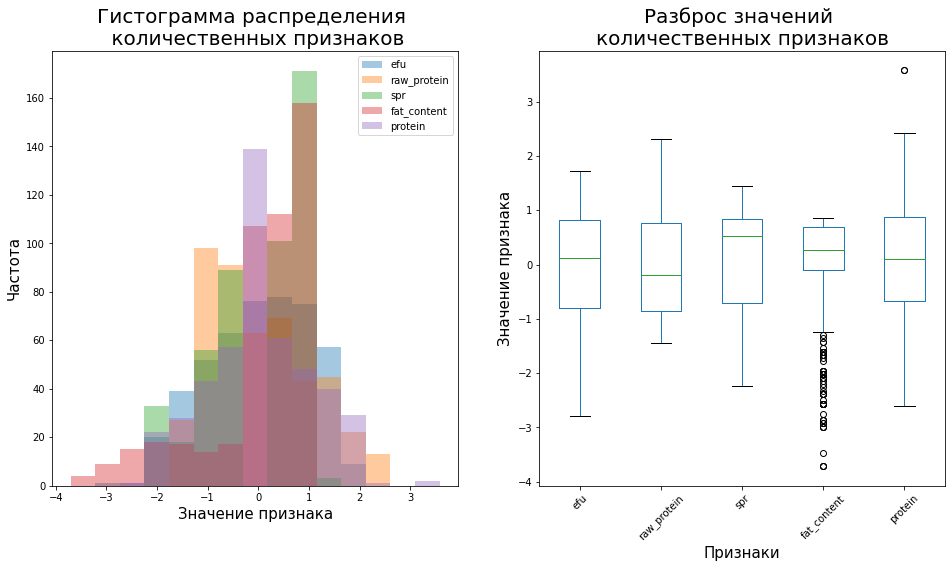

In [36]:
# создание функции для анализа отмасштабировнных количественных данных
def numetric_analysis (X_train, X_train_start):
    # создаем список количественных признаков
    numetric = list(X_train_start.select_dtypes([np.number]))
    
    # построим гистограмму частотности распределения и ящик с усами для количественных признаков тренировочной выборки
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

    X_train[numetric].plot(kind='hist', bins=15, ax=axes[0], alpha=0.4)
    axes[0].set_title('Гистограмма распределения \n количественных признаков', fontsize=20)
    axes[0].set_xlabel('Значение признака', fontsize=15)
    axes[0].set_ylabel('Частота', fontsize=15)

    X_train[numetric].plot(kind='box',   ax=axes[1], rot=45)
    axes[1].set_title('Разброс значений \nколичественных признаков', fontsize=20)
    axes[1].set_xlabel('Признаки', fontsize=15)
    axes[1].set_ylabel('Значение признака', fontsize=15)
    
    plt.show()

# анализ отмасштабированных количественных данных
numetric_analysis(X_train_1_final, X_train_1)

Данные успешно отмасштабированы, большая часть значений находится в промежутке (-3, 3), но есть и несколько выбросов у жирности молока `fat_content`, но они находятся в этом промежутке.

Теперь можно обучить первую модель линейной регрессии:

In [37]:
def creating_model_lr (X_train, y_train, X_test, y_test):
    # инициализируем модель линейной регрессии
    model_lr  = LinearRegression()

    # обучаем модель на тренировочной выборке
    model_lr.fit(X_train, y_train)

    # получаем предсказания модели на тестовой выборке и сохраняем предсказания в y_pred 
    y_pred = model_lr.predict(X_test)
    
    # расчет коэффициента детерминации
    r2 = r2_score(y_test, y_pred)
    return y_pred, r2, model_lr

# обучение первой модели
y_pred_1, r2_1, model_lr_1 = creating_model_lr(X_train_1_final, y_train_1, X_test_1_final, y_test_1)
print(f'Коэффициент детерминации первой модели (R2) = {r2_1:.3f}')

Коэффициент детерминации первой модели (R2) = 0.797


Коэффициент детерминации близок к 1, первая модель показывает себя хорошо в 79,7 процентах случаев, проведем еще анализ остатков:

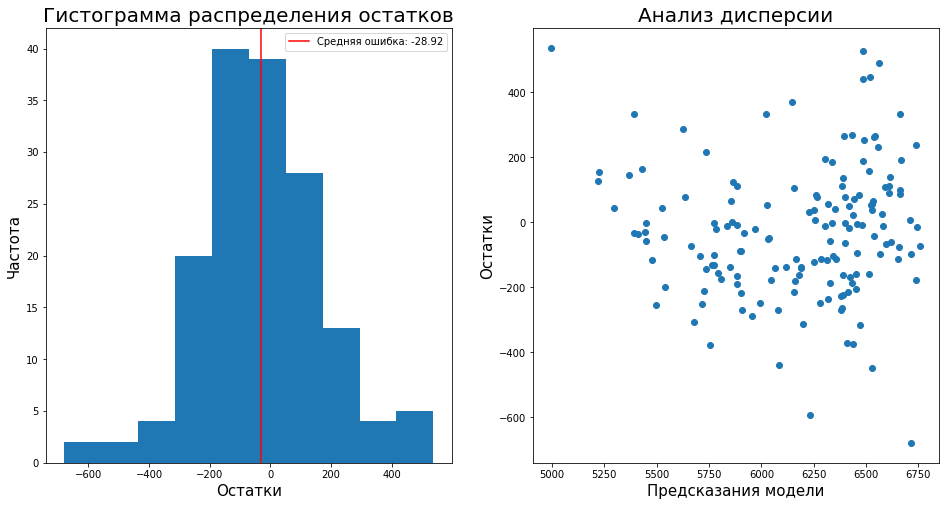

In [38]:
# создадим функцию для анализа остатков:
def residuals_analysis (y_test, y_pred):
    # расчет остатков
    residuals = y_test - y_pred
    
    # построение графиков: гистограмма частотности распределения и диаграмма рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков', fontsize=20)
    axes[0].set_xlabel('Остатки', fontsize=15)
    axes[0].set_ylabel('Частота', fontsize=15)
    axes[0].axvline(residuals.mean(),  color='r', label=f'Средняя ошибка: {residuals.mean():.2f}')
    axes[0].legend()

    axes[1].scatter(x=y_pred, y=residuals)
    axes[1].set_title('Анализ дисперсии', fontsize=20)
    axes[1].set_xlabel('Предсказания модели', fontsize=15)
    axes[1].set_ylabel('Остатки', fontsize=15)

    plt.show()

# проведем анализ остатков для первой модели
residuals_analysis(y_test_1, y_pred_1)

По гистограмме и диаграмме рассеяния остатков видно, что:
- средняя ошибка равна -28,92 кг, значит модель ошибается больше в меньшую сторону;
- остатки на диаграмме показывают, что модель может работать неустойчиво, поскольку разброс остатков непостоянен (имеет форму рупора), при больших значениях предсказаний разброс остатков больше.



### 5.2 Вторая модель линейной регрессии

Во второй модели попытаемся увеличить линейность зависимости некоторых входных признаков с целевым, для этого посмотрим еще раз на диаграммы рассеяния удоя `milk_yield` и отношения сахара к протеину в корме `spr`:

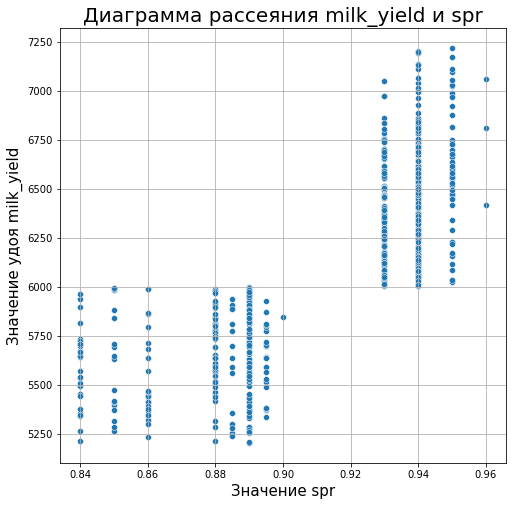

In [39]:
plt.subplots(figsize=(8,8))

sns.scatterplot(x='spr', y='milk_yield', data=ferma_main)
plt.title('Диаграмма рассеяния milk_yield и spr', fontsize=20)
plt.xlabel('Значение spr', fontsize=15)
plt.ylabel('Значение удоя milk_yield', fontsize=15)
plt.grid()

На диаграмме можно определить значения входного признака, при котором удой `milk_yield` становится выше 6000 кг. в год это значение - 0,92, поэтому можно увеличить линейность их зависимости преобразовав этот признак в категориальный бинарный признак, использовав эту границу:

In [40]:
# добавим столбец cat_spr, с условием если spr > 0.92 => высокое отношение сахара к протеину в корме, иначе низкое
ferma_main_2 = ferma_main
ferma_main_2['cat_spr'] = ferma_main_2['spr'].apply(lambda x: 'высокое' if x > 0.92 else 'низкое').astype('category')

# проверим на пропуски новые столбцы
ferma_main_2['cat_spr'].isna().sum()

0

В новых столбцах нет пропусков, значит добавление прошло корректно.

Для увеличения линейной зависимости возведем в квадрат значения показателя питательности корма коровы `efu`:

In [41]:
# возведение значений столбца efu в квадрат
ferma_main_2['efu_2'] = ferma_main_2['efu'] ** 2

Разделим дополненный датасет `ferma_main_2` на два датасета, уберем еще признак вкус молока `taste_milk`, так как его не будет в датасете к которому будем применять модель, также уберем жирность молока `fat_content` и содержание протеина в молоке `protein` т.к. это показатели самого молока и на удой они не влияют:
- `X_2` - входные признаки;
- `y_2` - целевой признак (`milk_yield`):

In [42]:
# уберем признак 'id', он будет только мешать модели, и уберем изначальный категоризированный столбец и признак taste_milk, fat_content и protein 
X_2 = ferma_main_2.drop(['milk_yield', 'id', 'spr', 'fat_content', 'taste_milk', 'protein', 'efu'], axis=1)
y_2 = ferma_main_2['milk_yield']

Далее выделим из них тренировочную (`X_train_2`, `y_train_2`) и тестовую (`X_test_2`, `y_test_2`) выборки и зафиксируем их с помощью `random_state`:

In [43]:
# разделение данных на тренировочную и тестовую выборки
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=RANDOM_STATE)

print('Размер выборки X_train_2:', X_train_2.shape)
print('Размер выборки y_train_2:', y_train_2.shape)
print('Размер выборки X_test_2:', X_test_2.shape)
print('Размер выборки y_test_2:', y_test_2.shape)

Размер выборки X_train_2: (471, 7)
Размер выборки y_train_2: (471,)
Размер выборки X_test_2: (157, 7)
Размер выборки y_test_2: (157,)


Размеры выборок по количеству строк совпадают, теперь необходимо масштабировать данные, воспользуемся функцией `scaler_numetric`:

In [44]:
# получаем отмасштабированные данные
X_train_scaled_2, X_test_scaled_2, scaler_2 = scaler_numetric(X_train_2, X_test_2)

print('Размер выборки X_train_scaled_2:', X_train_scaled_2.shape)
print('Размер выборки X_test_scaled_2:', X_test_scaled_2.shape)

Размер выборки X_train_scaled_2: (471, 2)
Размер выборки X_test_scaled_2: (157, 2)


Размеры выборок корректны.

Теперь необходимо кодировать категориальные признаки, воспользуемся функцией `encoder_categorial`:

In [45]:
# получаем закодированные данные
X_train_ohe_2, X_test_ohe_2, encoder_2 = encoder_categorial(X_train_2, X_test_2)

print('Размер выборки X_train_ohe_2:', X_train_ohe_2.shape)
print('Размер выборки X_test_ohe_2:', X_test_ohe_2.shape)

Размер выборки X_train_ohe_2: (471, 5)
Размер выборки X_test_ohe_2: (157, 5)


Размеры выборок корректны.

Сейчас объединим закодированные и отмасштабированные данные в датафрейм `X_train_2_final`, `X_test_2_final`:

In [46]:
# формирование финальной тренировочной и тестовой выборки
X_train_2_final, X_test_2_final = concat_data(X_train_scaled_2, X_test_scaled_2, X_train_ohe_2, X_test_ohe_2)

print('Размер выборки X_train_2_final:', X_train_2_final.shape)
print('Размер выборки X_test_2_final:', X_test_2_final.shape)

Размер выборки X_train_2_final: (471, 7)
Размер выборки X_test_2_final: (157, 7)


Объединение прошло успешно.

Теперь можно обучить вторую модель линейной регрессии, воспользовавшись функцией `creating_model_lr`:

In [47]:
# обучение второй модели
y_pred_2, r2_2, model_lr_2 = creating_model_lr(X_train_2_final, y_train_2, X_test_2_final, y_test_2)
print(f'Коэффициент детерминации второй модели (R2) = {r2_2:.3f}')

Коэффициент детерминации второй модели (R2) = 0.818


Коэффициент детерминации также близок к 1, вторая молель показывает себя лучше, чем первая на 2,1%, она показывает себя хорошо в 81,8% процентах случаев, проведем еще анализ остатков второй модели:

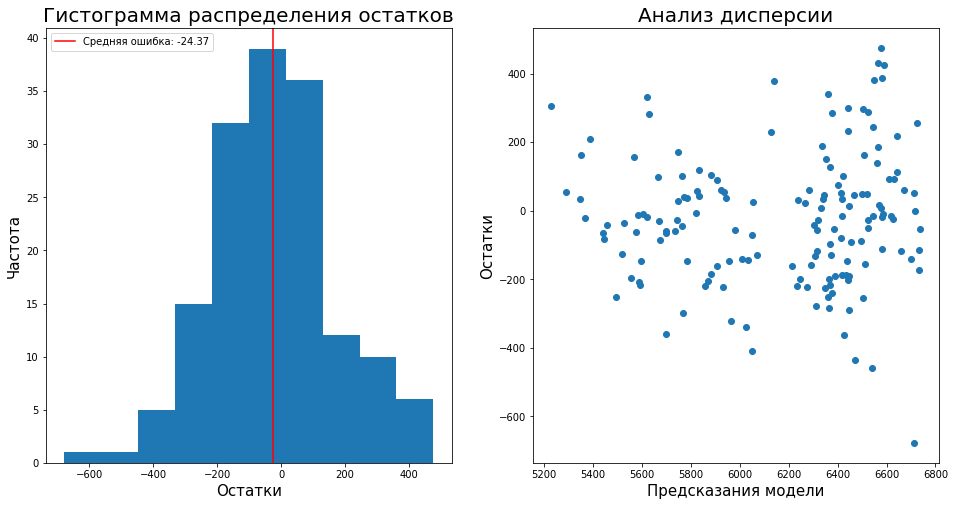

In [48]:
# анализ остатков второй модели
residuals_analysis(y_test_2, y_pred_2)

После категоризации признака отношения сахара к протеину в корме `spr` и удаления признаков вкус молока `taste_milk`, жирность молока `fat_content` и содержание протеина в молоке `protein`, вторая модель линейной регрессии стала немного лучше, а именно:
- повысился на 2,1% коэффициент детерминации до 81,8%;
- средняя ошибка на 4,5 кг. приблизилась к нулю, во второй модели она равна -24,37 кг;
- разброс остатков визуально стал более равномерным.

### 5.3 Третья модель линейной регрессии

Добавим еще один признак к имеющемуся датасету `ferma_main`: имя папы-быка из датасета `ferma_dad`:

In [49]:
# добавляем новый признак dad_bull_name из ferma_dad
ferma_main_3 = ferma_main_2
ferma_main_3 = ferma_main_3.merge(ferma_dad, on='id', how='left')

# изменение типа данных у нового столбца на category
ferma_main_3['dad_bull_name'] = ferma_main_3['dad_bull_name'].astype('category')

# проверим на пропуски новые столбцы
ferma_main_3['dad_bull_name'].isna().sum()

0

Добавление столбца прошло успешно, пустых строк нет.

Разделим дополненный датасет `ferma_main` на два датасета:
- `X_3` - входные признаки;
- `y_3` - целевой признак (`milk_yield`):

In [50]:
# уберем признак 'id', он будет только мешать модели, и уберем изначальный категоризированный столбец и признак taste_milk, fat_content и protein
X_3 = ferma_main_3.drop(['milk_yield', 'id', 'spr', 'fat_content', 'taste_milk', 'protein', 'efu'], axis=1)
y_3 = ferma_main_3['milk_yield']

Далее выделим из них тренировочную (`X_train_3`, `y_train_3`) и тестовую (`X_test_3`, `y_test_3`) выборки и зафиксируем их с помощью `random_state`:

In [51]:
# разделение данных на тренировочную и тестовую выборки
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, random_state=RANDOM_STATE)

print('Размер выборки X_train_3:', X_train_3.shape)
print('Размер выборки y_train_3:', y_train_3.shape)
print('Размер выборки X_test_3:', X_test_3.shape)
print('Размер выборки y_test_3:', y_test_3.shape)

Размер выборки X_train_3: (471, 8)
Размер выборки y_train_3: (471,)
Размер выборки X_test_3: (157, 8)
Размер выборки y_test_3: (157,)


Размеры выборок по количеству строк совпадают, теперь необходимо масштабировать данные, воспользуемся функцией `scaler_numetric`:

In [52]:
# получаем отмасштабированные данные
X_train_scaled_3, X_test_scaled_3, scaler_3 = scaler_numetric(X_train_3, X_test_3)

print('Размер выборки X_train_scaled_3:', X_train_scaled_3.shape)
print('Размер выборки X_test_scaled_3:', X_test_scaled_3.shape)

Размер выборки X_train_scaled_3: (471, 2)
Размер выборки X_test_scaled_3: (157, 2)


Размеры выборок корректны.

Теперь необходимо кодировать категориальные признаки, воспользуемся функцией `encoder_categorial`:

In [53]:
# получаем закодированные данные
X_train_ohe_3, X_test_ohe_3, encoder_3 = encoder_categorial(X_train_3, X_test_3)

print('Размер выборки X_train_ohe_3:', X_train_ohe_3.shape)
print('Размер выборки X_test_ohe_3:', X_test_ohe_3.shape)

Размер выборки X_train_ohe_3: (471, 8)
Размер выборки X_test_ohe_3: (157, 8)


Размеры выборок корректны.

Сейчас объединим закодированные и отмасштабированные данные в датафрейм `X_train_3_final`, `X_test_3_final`:

In [54]:
# формирование финальной тренировочной и тестовой выборки
X_train_3_final, X_test_3_final = concat_data(X_train_scaled_3, X_test_scaled_3, X_train_ohe_3, X_test_ohe_3)

print('Размер выборки X_train_3_final:', X_train_3_final.shape)
print('Размер выборки X_test_3_final:', X_test_3_final.shape)

Размер выборки X_train_3_final: (471, 10)
Размер выборки X_test_3_final: (157, 10)


Объединение прошло успешно.

Теперь можно обучить третью модель линейной регрессии, воспользовавшись функцией `creating_model_lr`:

In [55]:
# обучение третьей модели
y_pred_3, r2_3, model_lr_3 = creating_model_lr(X_train_3_final, y_train_3, X_test_3_final, y_test_3)
print(f'Коэффициент детерминации третьей модели (R2) = {r2_3:.3f}')

Коэффициент детерминации третьей модели (R2) = 0.825


Коэффициент детерминации также близок к 1, третья модель показывает себя лучше, чем вторая на 0,7%, она показывает себя хорошо в 82,5% процентах случаев, проведем еще анализ остатков третьей модели:

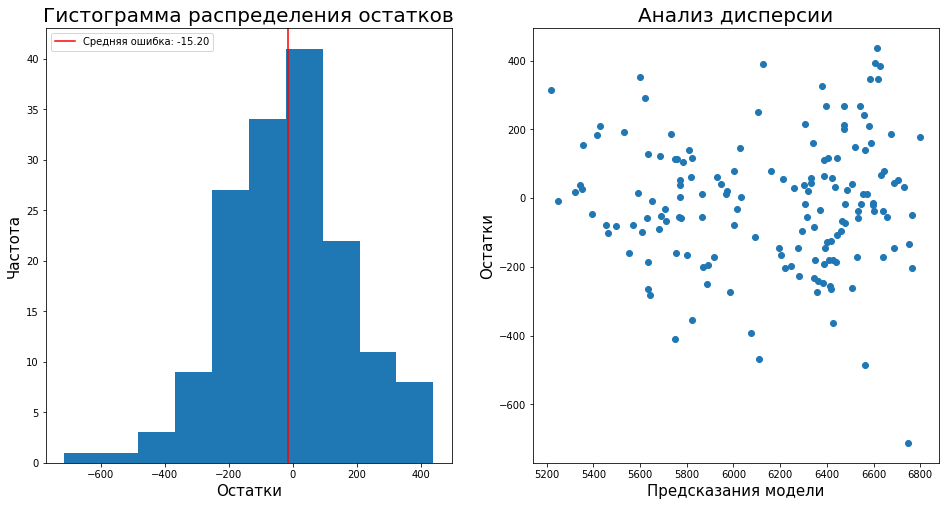

In [56]:
# анализ остатков третьей модели
residuals_analysis(y_test_3, y_pred_3)

После добавления нового входного признака имени папы-быка `dad_bull_name`, третья модель линейной регрессии стала еще немного лучше, а именно:
- повысился на 0,7% коэффициент детерминации до 82,5%;
- средняя ошибка еще на 9 кг. приблизилась к нулю, в третьей модели она равна -15,20 кг;
- разброс остатков визуально стал более равномерным при всех значениях предсказания модели (но есть один выброс).

### 5.4 Сравнение трех моделей линейной регрессии

Сравним остатки трех моделей:

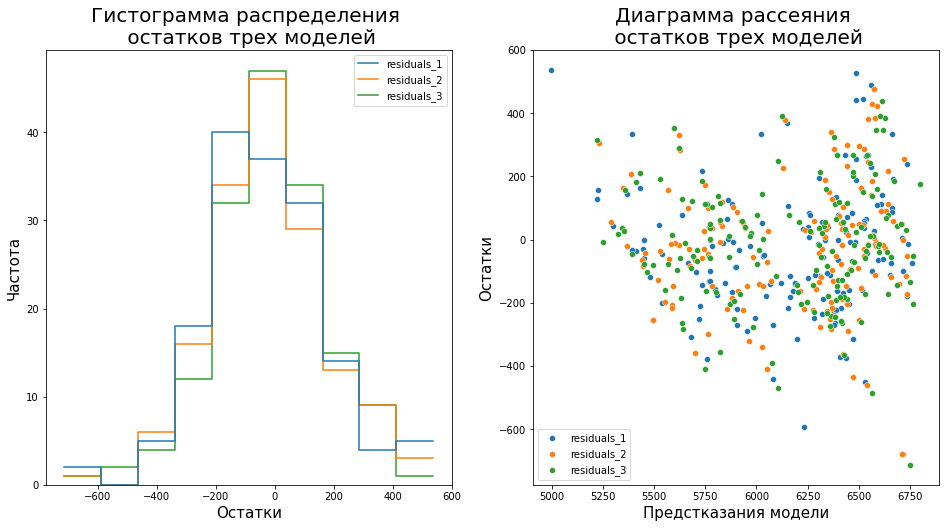

In [57]:
# сведение остатков и предсказаний в один датафрейм
residuals = pd.DataFrame({'y_test_1':np.array(y_test_1), 'y_pred_1':np.array(y_pred_1), 'residuals_1':np.array(y_test_1 - y_pred_1), 
                          'y_test_2':np.array(y_test_2), 'y_pred_2':np.array(y_pred_2), 'residuals_2':np.array(y_test_2 - y_pred_2),
                          'y_test_3':np.array(y_test_3), 'y_pred_3':np.array(y_pred_3), 'residuals_3':np.array(y_test_3 - y_pred_3)
                         })

# построение графиков: гистограмма частотности распределения и диаграмма рассеяния всех трех моделей
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

sns.histplot(data=residuals[['residuals_1', 'residuals_2', 'residuals_3']], 
             element="step", 
             fill=False, 
             bins=10, 
             ax=axes[0]
            )
axes[0].set_title('Гистограмма распределения \n остатков трех моделей', fontsize=20)
axes[0].set_xlabel('Остатки', fontsize=15)
axes[0].set_ylabel('Частота', fontsize=15)

for i in range(3):
    sns.scatterplot(data=residuals, x='y_pred_' + str(i+1), y='residuals_' + str(i+1), ax=axes[1], label='residuals_' + str(i+1))
axes[1].set_title('Диаграмма рассеяния \n остатков трех моделей', fontsize=20)
axes[1].set_xlabel('Предстказания модели', fontsize=15)
axes[1].set_ylabel('Остатки', fontsize=15)

plt.show()

По графикам видно, что:
- каждая следующая модель давала все больше предсказаний с около нулевой ошибкой;
- отрицательных ошибок стало меньше (ступени слева и справа от пика выравниваются по высоте).

Сведем коэффициенты детерминации в одну таблицу и добавим к ним другие метрики (`MAE` - средняя абсолютная ошибка, `MSE` - среднеквадратичная ошибка, `RMSE` - корень среднеквадратичной ошибки):

In [58]:
# создаем функцию для расчета метрик модели линейной регрессии
def analysis_metrics (y_test, y_pred, name):
    r_2 = round(r2_score(y_test, y_pred), 3)
    mae = round(mean_absolute_error(y_test, y_pred), 2)
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), 2)
    row = pd.Series([name, r_2, mae, mse, rmse])
    return row

# сводим метрики в один датафрейм
metrics_model = pd.DataFrame([analysis_metrics(y_test_1, y_pred_1, 'Первая модель'),
                              analysis_metrics(y_test_2, y_pred_2, 'Вторая модель'),
                              analysis_metrics(y_test_3, y_pred_3, 'Третья модель')]
                            )

# именуем столбцы
metrics_model.columns = ['model', 'r2', 'mae', 'mse', 'rmse']

# выводим метрики
metrics_model

model     r2     mae       mse    rmse
0  Первая модель  0.797  156.78  41277.95  203.17
1  Вторая модель  0.818  149.04  37030.91  192.43
2  Третья модель  0.825  146.16  35673.89  188.88

Сравнив метрики выбираем третью модель, по следующим причинам:
- лучший коэффициент детерминации `r2` (0,825);
- значение корня среднеквадратичной ошибки у третьей модели меньше (188,88 кг.), что говорит о меньшем количестве выбросов в предсказаниях;
- третья модель имеет среднюю абсолютную ошибку `mae` - 146,16 кг.

Посмотрим на доверительный интервал третьей модели:

In [59]:
print('95% доверительный интервал для третьей модели =', st.norm.interval(confidence=0.95, loc=np.mean(y_pred_3), scale=st.sem(y_pred_3)))

95% доверительный интервал для третьей модели = (6092.340075854289, 6221.375070058381)


### 5.5 Применение модели на данных

Применим третью модель для предсказания удоя коров `milk_yield` для датафрейма `cow_buy`, но сначала подготовим датафрейм к предсказаниям, добавим столбцы показателя питательности корма `efu`, содержания сырого протеина в корме `raw_protein` и  отношения сахара к протеину в корме `spr`, возьмем их средние значения, с учетом возраста коровы `age`, увеличенные на 5% (желание заказчика):

In [60]:
cow_buy_final = cow_buy

# добавление новых столбцов, с учетом возраста коровы
for i in ['efu', 'spr', 'raw_protein']:
    cow_buy_final[i] = ferma_main[i].mean() * 1.05

# проверим на пропуски новые столбцы
cow_buy_final[['efu', 'spr', 'raw_protein']].isna().sum()

efu            0
spr            0
raw_protein    0
dtype: int64

Пропусков нет

Категоризируем признак `spr` и возведем в квадрат признак `efu`:

In [61]:
# добавим столбец cat_spr, с условием если spr > 0.92 => высокое отношение сахара к протеину в корме, иначе низкое
cow_buy_final['cat_spr'] = cow_buy_final['spr'].apply(lambda x: 'высокое' if x > 0.92 else 'низкое').astype('category')

# возведение в квадрат efu
cow_buy_final['efu_2'] = cow_buy_final['efu'] ** 2

# проверим на пропуски новый столбец
cow_buy_final['cat_spr'].isna().sum()

0

Пропусков нет.

Уберем изначальные категоризированный признак:

In [62]:
# удаление столбцов
cow_buy_final = cow_buy_final.drop('spr', axis=1)

Расположим столбцы в том же порядке, как и в обучающей выборке:

In [63]:
# установление порядка столбцов
cow_buy_final = cow_buy_final[X_test_3.columns]

Теперпь отмасштабируем количественные признаки и закодируем категориальные:

In [64]:
# получаем отмасштабированные данные
cow_buy_final_scaled = scaler_3.transform(cow_buy_final[list(cow_buy_final.select_dtypes([np.number]))])
cow_buy_final_scaled = pd.DataFrame(cow_buy_final_scaled, columns=list(cow_buy_final.select_dtypes([np.number])))

# получаем закодированные данные
cow_buy_final_ohe = encoder_3.transform(cow_buy_final[list(cow_buy_final.select_dtypes('category'))])
encoder_col_names_cow_buy = encoder_3.get_feature_names()
cow_buy_final_ohe = pd.DataFrame(cow_buy_final_ohe, columns=encoder_col_names_cow_buy)

# формирование финального датафрейма
cow_buy_final_for_lin_model = pd.concat([cow_buy_final_ohe, cow_buy_final_scaled], axis=1)

# проверка на совпадение столбцов
print(cow_buy_final_for_lin_model.info())
print(X_test_3_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   x0_РефлешнСоверинг  16 non-null     float64
 1   x1_холмистое        16 non-null     float64
 2   x2_Соверин          16 non-null     float64
 3   x3_менее_2_лет      16 non-null     float64
 4   x4_низкое           16 non-null     float64
 5   x5_Буйный           16 non-null     float64
 6   x5_Геркулес         16 non-null     float64
 7   x5_Соловчик         16 non-null     float64
 8   raw_protein         16 non-null     float64
 9   efu_2               16 non-null     float64
dtypes: float64(10)
memory usage: 1.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   x0_РефлешнСоверинг  157 non-null    float64
 1   x1_хол

Данные готовы, можно получить предсказания третьей модели линейной регрессии:

In [65]:
# получение предсказаний
milk_yield_pred = model_lr_3.predict(cow_buy_final_for_lin_model)

# добавление столбца с предсказанным удоем
cow_buy_final['milk_yield_pred'] = milk_yield_pred
cow_buy_final

raw_protein            breed type_of_pasture breed_dad_bull          age  \
0   2019.947532   Вис Бик Айдиал       холмистое         Айдиал  более_2_лет   
1   2019.947532   Вис Бик Айдиал       равнинное        Соверин  менее_2_лет   
2   2019.947532  РефлешнСоверинг       равнинное        Соверин  более_2_лет   
3   2019.947532  РефлешнСоверинг       холмистое         Айдиал  более_2_лет   
4   2019.947532  РефлешнСоверинг       равнинное         Айдиал  более_2_лет   
5   2019.947532  РефлешнСоверинг       равнинное        Соверин  менее_2_лет   
6   2019.947532   Вис Бик Айдиал       равнинное        Соверин  более_2_лет   
7   2019.947532  РефлешнСоверинг       холмистое         Айдиал  менее_2_лет   
8   2019.947532   Вис Бик Айдиал       холмистое        Соверин  более_2_лет   
9   2019.947532  РефлешнСоверинг       равнинное        Соверин  более_2_лет   
10  2019.947532   Вис Бик Айдиал       холмистое         Айдиал  более_2_лет   
11  2019.947532   Вис Бик Айдиал       холмистое        Соверин  менее_2_лет   
12  2019.947532  РефлешнСоверинг       холмистое         Айдиал  более_2_лет   
13  2019.947532   Вис Бик Айдиал       холмистое        Соверин  более_2_лет   
14  2019.947532  РефлешнСоверинг       равнинное        Соверин  менее_2_лет   
15  2019.947532   Вис Бик Айдиал       равнинное        Соверин  более_2_лет   

    cat_spr       efu_2 dad_bull_name  milk_yield_pred  
0   высокое  233.361138      Геркулес      6609.919297  
1   высокое  233.361138        Буйный      6378.711028  
2   высокое  233.361138         Барин      6283.999775  
3   высокое  233.361138        Буйный      6593.089377  
4   высокое  233.361138        Буйный      6542.146066  
5   высокое  233.361138      Геркулес      6425.380218  
6   высокое  233.361138        Буйный      6571.259737  
7   высокое  233.361138        Буйный      6400.540668  
8   высокое  233.361138      Соловчик      6344.707860  
9   высокое  233.361138      Геркулес      6617.928926  
10  высокое  233.361138      Геркулес      6609.919297  
11  высокое  233.361138         Барин      6127.474742  
12  высокое  233.361138        Буйный      6593.089377  
13  высокое  233.361138      Соловчик      6344.707860  
14  высокое  233.361138      Геркулес      6425.380218  
15  высокое  233.361138        Буйный      6571.259737

Все коровы по прогнозу будут давать более 6000 кг. молока в год.

## 6. Обучение модели логистической регрессии

### 6.1 Модель логистической регрессии

В качестве основы для логистической регрессии возьмем подготовленный датасет для 3 медели линейной регрессии `ferma_main_3` и выберем только признаки которые влияют на вкус молока `taste_milk`: 
- показатели корма:
    - `efu_2`;
    - `raw_protein`;
    - `spr`;
- `fat_content`;

и разделим его на два датасета:
- `X_4` - входные признаки;
- `y_4` - целевой признак (`taste_milk`):

In [66]:
# выбираем нужные столбцы
X_4 = ferma_main_3[['efu_2', 'raw_protein', 'fat_content', 'spr']]

# заменим вкусно на 1, не вкусно на 0
y_4 = ferma_main_3['taste_milk'].replace({'вкусно': 1, 'не вкусно': 0})

Далее выделим из них тренировочную (`X_train_4`, `y_train_4`) и тестовую (`X_test_4`, `y_test_4`) выборки и зафиксируем их с помощью `random_state`:

In [67]:
# разделение данных на тренировочную и тестовую выборки
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, random_state=RANDOM_STATE)

print('Размер выборки X_train_4:', X_train_4.shape)
print('Размер выборки y_train_4:', y_train_4.shape)
print('Размер выборки X_test_4:', X_test_4.shape)
print('Размер выборки y_test_4:', y_test_4.shape)

Размер выборки X_train_4: (471, 4)
Размер выборки y_train_4: (471,)
Размер выборки X_test_4: (157, 4)
Размер выборки y_test_4: (157,)


Размеры выборок по количеству строк совпадают, теперь необходимо масштабировать данные, воспользуемся функцией `scaler_numetric`:

In [68]:
# получаем отмасштабированные данные
X_train_scaled_4, X_test_scaled_4, scaler_4 = scaler_numetric(X_train_4, X_test_4)

#print('Размер выборки X_train_scaled_4:', X_train_scaled_4.shape)
#print('Размер выборки X_test_scaled_4:', X_test_scaled_4.shape)

Размеры выборок корректны.

Теперь необходимо кодировать категориальные признаки, воспользуемся функцией `encoder_categorial`:

In [69]:
# получаем закодированные данные
X_train_ohe_4, X_test_ohe_4, encoder_4 = encoder_categorial(X_train_4, X_test_4)

print('Размер выборки X_train_ohe_4:', X_train_ohe_4.shape)
print('Размер выборки X_test_ohe_4:', X_test_ohe_4.shape)

Размер выборки X_train_ohe_4: (471, 0)
Размер выборки X_test_ohe_4: (157, 0)


Размеры выборок корректны.

Сейчас объединим закодированные и отмасштабированные данные в датафрейм `X_train_4_final`, `X_test_4_final`:

In [70]:
# формирование финальной тренировочной и тестовой выборки
X_train_4_final, X_test_4_final = concat_data(X_train_scaled_4, X_test_scaled_4, X_train_ohe_4, X_test_ohe_4)

print('Размер выборки X_train_4_final:', X_train_4_final.shape)
print('Размер выборки X_test_4_final:', X_test_4_final.shape)

Размер выборки X_train_4_final: (471, 4)
Размер выборки X_test_4_final: (157, 4)


Объединение прошло успешно.

Теперь можно обучить модель логистической регрессии:

In [71]:
# инициализируем модель логистической регрессии
clf = LogisticRegression()

# обучаем модель на тренировочной выборке
clf = clf.fit(X_train_4_final, y_train_4)

# получаем предсказания модели на тестовой выборке и сохраняем предсказания в y_pred_4 
y_pred_4 = clf.predict(X_test_4_final)

Модель готова, пресказания получены.

### 6.2 Анализ модели логистической регрессии

Теперь оценим качество модели логистической регрессии по нескольким метрикам (доля верных ответов - `accuracy`, точность, с которой модель присваивает объектам класс 1 - `precision` и смогла ли модель классификации присвоить класс 1 всем объектам этого класса - `recall`) и построим матрицу ошибок:

Accuracy:  0.599
Precision:  0.602
Recall:  0.841


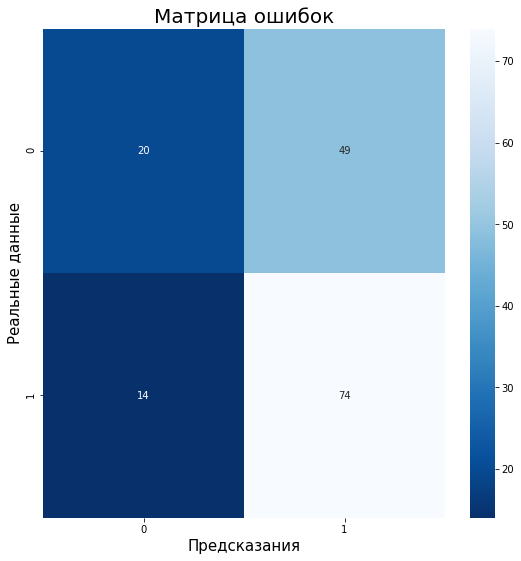

In [72]:
# создание функции для анализа моледи логистической регрессии
def logistic_regression_analysis (y_test, y_pred):
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
    print('Precision: ', round(precision_score(y_test, y_pred), 3))
    print('Recall: ', round(recall_score(y_test, y_pred), 3))

    # построение матрицы ошибок
    fig, axes = plt.subplots(figsize=(9, 9))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('Реальные данные',fontsize=15)
    plt.xlabel('Предсказания',fontsize=15)
    plt.title('Матрица ошибок',fontsize=20)
    plt.show()
    
# анализ логистической регрессии
logistic_regression_analysis (y_test_4, y_pred_4)

Выводы по анализу:
- точность `accuracy` у получившийся модели получилась не очень, всего в 59,9% случаев модель правильно предсказывает вкус молока;
- в 60,2 % случаев модель присваивает класс 1 объектам класса 0 (`precision`);
- в 84,1% случаев модель присваивает класс 0 объекту с классом 1 (`recall`).

Для заказчика главное — вкусное молоко, поэтому необходимо свести к минимуму ложноположительные предсказания (ошибки 1-го рода), которых модель выдает 49, т.е. увеличить `precision` до 1, делать это будем путем изменения порога принадлежности к классу 1:

In [73]:
# функция для посика порога для максимизации precision
def threshold_for_max_precision (clf, X_test, y_test):
    threshold = 0.500
    precision = 0
    while precision < 1:
        y_pred = np.where(clf.predict_proba(X_test)[:,1] > threshold, 1, 0)
        threshold += 0.001
        precision = round(precision_score(y_test, y_pred), 3)
    print('Значение порога для максимизации precision:', round(threshold, 3) - 0.001)

# получение порога
threshold_for_max_precision(clf, X_test_4_final, y_test_4)

Значение порога для максимизации precision: 0.78


Accuracy:  0.49
Precision:  1.0
Recall:  0.091


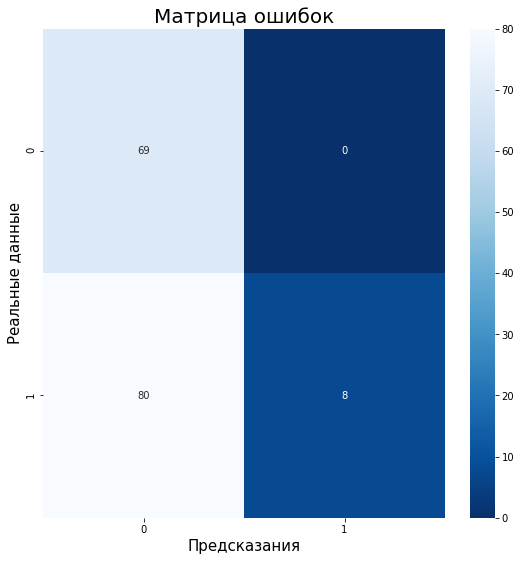

In [74]:
# поменяем порог вероятности принадлежности к классу 1 на 0,780 и получим новые предсказания
y_pred_4_new = np.where(clf.predict_proba(X_test_4_final)[:,1] > 0.780, 1, 0)

# проведем анализ предсказаний с обновленным порогом
logistic_regression_analysis (y_test_4, y_pred_4_new)

Ошибки первого рода сведены в минимуму: `precision` равен 1, но точность модели `accuracy` упала до 49%.

### 6.3 Применение модели логистической регрессии

Подготовим данные для применения логистической регрессии:

In [75]:
# за основу возьмем датафрейм cow_buy
cow_buy_final_log_model = cow_buy

# выберем нужные столбцы и расположим столбцы в порядке, что и в тестовой выборке
cow_buy_final_log_model = cow_buy_final_log_model[['efu_2', 'raw_protein', 'fat_content', 'spr']]
cow_buy_final_log_model = cow_buy_final_log_model[X_test_4.columns]

# получаем отмасштабированные данные
cow_buy_final_scaled = scaler_4.transform(cow_buy_final_log_model[list(cow_buy_final_log_model.select_dtypes([np.number]))])
cow_buy_final_scaled = pd.DataFrame(cow_buy_final_scaled, columns=list(cow_buy_final_log_model.select_dtypes([np.number])))

# получаем закодированные данные
cow_buy_final_ohe = encoder_4.transform(cow_buy_final_log_model[list(cow_buy_final_log_model.select_dtypes('category'))])
encoder_col_names_cow_buy = encoder_4.get_feature_names()
cow_buy_final_ohe = pd.DataFrame(cow_buy_final_ohe, columns=encoder_col_names_cow_buy)

# формирование финального датафрейма
cow_buy_final_for_log_model = pd.concat([cow_buy_final_ohe, cow_buy_final_scaled], axis=1)

# проверка на совпадение столбцов
print(cow_buy_final_for_log_model.info())
print(X_test_4_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   efu_2        16 non-null     float64
 1   raw_protein  16 non-null     float64
 2   fat_content  16 non-null     float64
 3   spr          16 non-null     float64
dtypes: float64(4)
memory usage: 640.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   efu_2        157 non-null    float64
 1   raw_protein  157 non-null    float64
 2   fat_content  157 non-null    float64
 3   spr          157 non-null    float64
dtypes: float64(4)
memory usage: 5.0 KB
None


Данные готовы, можно получить предсказания:

In [76]:
# получение предсказаний
taste_milk_pred = np.where(clf.predict_proba(cow_buy_final_for_log_model)[:,1] > 0.780, 1, 0)

# добавление столбца с предсказанным вкусом молока
cow_buy_final['taste_milk_pred'] = taste_milk_pred
cow_buy_final['taste_milk_pred'] = cow_buy_final['taste_milk_pred'].replace({1: 'вкусно', 0: 'не вкусно'})
cow_buy_final

raw_protein            breed type_of_pasture breed_dad_bull          age  \
0   2019.947532   Вис Бик Айдиал       холмистое         Айдиал  более_2_лет   
1   2019.947532   Вис Бик Айдиал       равнинное        Соверин  менее_2_лет   
2   2019.947532  РефлешнСоверинг       равнинное        Соверин  более_2_лет   
3   2019.947532  РефлешнСоверинг       холмистое         Айдиал  более_2_лет   
4   2019.947532  РефлешнСоверинг       равнинное         Айдиал  более_2_лет   
5   2019.947532  РефлешнСоверинг       равнинное        Соверин  менее_2_лет   
6   2019.947532   Вис Бик Айдиал       равнинное        Соверин  более_2_лет   
7   2019.947532  РефлешнСоверинг       холмистое         Айдиал  менее_2_лет   
8   2019.947532   Вис Бик Айдиал       холмистое        Соверин  более_2_лет   
9   2019.947532  РефлешнСоверинг       равнинное        Соверин  более_2_лет   
10  2019.947532   Вис Бик Айдиал       холмистое         Айдиал  более_2_лет   
11  2019.947532   Вис Бик Айдиал       холмистое        Соверин  менее_2_лет   
12  2019.947532  РефлешнСоверинг       холмистое         Айдиал  более_2_лет   
13  2019.947532   Вис Бик Айдиал       холмистое        Соверин  более_2_лет   
14  2019.947532  РефлешнСоверинг       равнинное        Соверин  менее_2_лет   
15  2019.947532   Вис Бик Айдиал       равнинное        Соверин  более_2_лет   

    cat_spr       efu_2 dad_bull_name  milk_yield_pred taste_milk_pred  
0   высокое  233.361138      Геркулес      6609.919297       не вкусно  
1   высокое  233.361138        Буйный      6378.711028       не вкусно  
2   высокое  233.361138         Барин      6283.999775       не вкусно  
3   высокое  233.361138        Буйный      6593.089377       не вкусно  
4   высокое  233.361138        Буйный      6542.146066       не вкусно  
5   высокое  233.361138      Геркулес      6425.380218       не вкусно  
6   высокое  233.361138        Буйный      6571.259737       не вкусно  
7   высокое  233.361138        Буйный      6400.540668       не вкусно  
8   высокое  233.361138      Соловчик      6344.707860       не вкусно  
9   высокое  233.361138      Геркулес      6617.928926       не вкусно  
10  высокое  233.361138      Геркулес      6609.919297       не вкусно  
11  высокое  233.361138         Барин      6127.474742       не вкусно  
12  высокое  233.361138        Буйный      6593.089377       не вкусно  
13  высокое  233.361138      Соловчик      6344.707860       не вкусно  
14  высокое  233.361138      Геркулес      6425.380218       не вкусно  
15  высокое  233.361138        Буйный      6571.259737          вкусно

Предсказания модели логистической регрессии получены, все коровы дают не вкусное молоко.

Критериям фермера (чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным) удовлетворяет одна корова представленная в `cow_buy` - это буренка под порядковым номером 15. 

## 7. Итоговые выводы

В проекте "Модели машинного обучения для выбора коров" проделана работа по изучению данных и их предобработке, а именно были:
- заменены некорректные записи (ошибки в написании) категориальных данных;
- удалены явные удбликаты;
- заменены типы данных для столбцов с категориальными признаками.

Затем были проанализированны количественные признаки и выявлено, что:
- удой `milk_yield`, после удаления аномального значения (выброса):
    - имеет нормальное распределение;
    - все значения расположены в пределах нормального значения параметра;
- показатель питательности корма коровы `efu`, содержание сырого протеина в корме `raw_protein`:
    - не имеет нормального распределения, т.к. есть несколько пиков;
    - все значения расположены в пределах нормального значения параметра;
- отношение сахара к протеину в корме коровы `spr`:
    - распределение не похоже на нормальное, т.к. можно выделить три отдельных "распределения", это похоже на три вида корма по отношению сахара к протеину в корме коровы;
    - все значения расположены в пределах нормального значения параметра;
- содержание жиров в молоке `fat_content`:
    - распределение не похоже на нормальное, т.к. можно выделить два ярковыаженных пика
    - не все значения расположены в пределах нормального значения параметра, есть много выбросов меньше нормальных значений, но такие значения вполне возможны, они отличаются от основной массы не в разы, это не выбросы;
- содержание белков в молоке `protein`:
    - имеет нормальное распределение;
    - не все значения расположены в пределах нормального значения параметра, есть несколько выбросов за пределом нормальных значений, но такие значения вполне возможны, они отличаются от основной массы не в разы, это не выбросы.

Потом были проанализированны категориальные признаки и выявлено, что:
- коров породы Вис Бик Айдиал больше примерно на 120 голов, чем коров породы РефлешнСоверинг;
- коров, которые паслись на холмах примерно на 80 голов больше, чем коров пасшихся на равнине;
- породы пап этих коров разделились поровну;
- больше коров дают вкусное молоко;
- коров старше двух лет в 5 раз больше, чем коров младше двух лет;
- всех больше коров от быков-пап: Барин и Буйный.

При корреляционном анализе было выявлено, что:
- между удоем `milk_yield` и показателем питательности корма `efu` и отношением сахара к протеину в корме `spr` есть небольшая линейная зависимость;
- также есть зависимость показателя удоя `milk_yield` от возраста коровы `age` и породы папы-быка `breed_dad_bull`;
- у остальных признаков взаимосвязь с удоем `milk_yield` не линейная;
- на диаграммах рассеяния удоя `milk_yield` и отношения сахара к протеину в корме `spr` и жирностью молока `fat_content`, можно определить значения входного признака, при котором удой `milk_yield` становится выше 6000 кг. в год;
- среди зависимостей признаков между собой можно выделить высокую зависимость возраста коровы `age` от показателя питательности корма `efu`, отношения сахара к протеину в корме `spr` и жирности молока `fat_content` (коэффициент 0,77, 0,72 и 0,68 соответственно), а также высокая зависимость у показателя питательности корма `efu` и жирности молока `fat_content`(коэффициент 0,72), но о мультиколлинеарности речь не идет;
- значения признаков разношерстны (значения отношения сахара к протеину в корме `spr` не превышают 1, а значения содержания сырого протеина в корме `raw_protein` от 1600 до 2400).

Затем было создано и обучено три модели линейной регрессии для определения удоя `milk_yield`:
- первая модель была обучена на сырых данных из `ferma_main`;
- во второй модели был категоризирован признак: отношение сахара к протеину в корме `spr` (высокое/низкое), для увеличения зависимости от целевого признака удоя `milk_yield`, и были убраны признаки: жирность молока `fat_content` и содержание протеина в молоке `protein`, также был возведен в квадрат признак: показатель питательности корма коровы `efu`;
- в третьей модели был добавлен еще один признак: имя папы-быка `dad_bull_name`.

Затем по четырем метрикам: `R2`, `MSE`, `MAE` и `RMSE` лучшей была выбрана третья модель и она была применена для предсказания удоя на данных о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

Затем была создана и обучена модель логистической регрессии для определения вкуса молока `taste_milk`, которая также была применена для предсказания удоя на данных о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

В итоге среди буренок, предложенных к продаже, оказалась лишь одна корова, которая удовлетворяет критериям фермера (чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным), это буренка под номером 15.